# Basic Approach for Trace Clustering
## Kmeans + One Hot Encoding

Requirements:
- ~~implement basic approach (one-hot-enconding + kmeans)~~
- ~~hyperparameter experiments (grid-search)~~
- ~~interpretation of clusters (one municipal? etc.)~~
- ~~Notebook nicely presenting the clustering results for different hyperparameters~~

In [38]:
import pandas as pd

from practical.ProcessMining.group1.shared import utils
import pm4py
from pm4py.algo.discovery.heuristics import algorithm as heuristics_miner
from pm4py.objects.conversion.log import converter as log_converter
from sklearn import metrics
from joblib import Parallel, delayed
import numpy as np

from sklearn.cluster import KMeans
from sklearn.preprocessing import OneHotEncoder
from sklearn.metrics import silhouette_score
from sklearn.model_selection import ParameterGrid

BASE = utils.SAMPLES_PATH
real_path = BASE / "DomesticDeclarations_cleansed.csv"
event_log_raw = utils.import_csv(BASE / "DomesticDeclarations_cleansed.csv")

In [39]:
def filter_rare_traces(log, threshold=2):
    case_counts = log.groupby('case:concept:name').size()
    frequent_traces = case_counts[case_counts >= threshold].index
    
    filtered_event_log = log[log['case:concept:name'].isin(frequent_traces)]
    return filtered_event_log

def split_by_date(log, date="2018"):
    date = pd.to_datetime(date).tz_localize('UTC')
    
    return log[log['time:timestamp'] < date], log[log['time:timestamp'] >= date]

def get_activities(log):
    return list(log['concept:name'].unique())

def get_df_by_traces(log):
    return log.groupby('case:concept:name')["concept:name"].apply(list).reset_index()

def hot_encode_traces(log, traces_df):
    traces = traces_df["concept:name"].to_list()
    all_activities = get_activities(log)
    
    # One-hot encode the event log
    one_hot_encoder = OneHotEncoder(sparse_output=False, categories=[all_activities], handle_unknown='ignore')
    one_hot_encoder.fit(np.array(all_activities).reshape(-1, 1))
    
    # Using dictionary comprehension to encode traces
    encoded_traces = [one_hot_encoder.transform(np.array(trace).reshape(-1, 1)).sum(axis=0) for trace in traces]
    
    # Stacking the encoded traces to form a sampled event log
    return np.vstack(encoded_traces)

def custom_metrics(log, _encoded_log, cluster, petri_net, init_marking, final_marking, weights=None):
    if weights is None:
        weights = {"ss": 0.4, "f": 0.25, "p": 0.35}
    
    ss = metrics.silhouette_score(_encoded_log, cluster)
    
    fitness = pm4py.conformance.fitness_alignments(log, petri_net, init_marking, final_marking)["averageFitness"]
    precision = pm4py.conformance.precision_alignments(log, petri_net, init_marking, final_marking)

    return weights["ss"] * ss + weights["f"] * fitness + weights["p"] * precision

def split_by_cluster(_event_log):
    _cluster_sublogs = {}
    for _cluster_label in np.unique(_event_log['cluster']):
        _cluster_sublogs[_cluster_label] = _event_log[_event_log['cluster'] == _cluster_label]
        
    _cluster_sublogs_sorted = dict(reversed(sorted(_cluster_sublogs.items(), key=lambda item: item[1]['case:concept:name'].nunique())))
    
    return _cluster_sublogs_sorted

## Event log preprocessing

In [49]:
event_log_preprocessed = filter_rare_traces(event_log_raw, threshold=2)

before_2018, from_2018 = split_by_date(event_log_preprocessed, "2018")
before_2018 = filter_rare_traces(before_2018, threshold=2)
from_2018 = filter_rare_traces(from_2018, threshold=2)

LOG_VERSIONS = [event_log_preprocessed, from_2018, before_2018]

## Event log sampling and encoding

In [41]:
event_log_sampled = event_log_preprocessed.sample(n=1000)

traces = get_df_by_traces(event_log_sampled)

encoded_log = hot_encode_traces(event_log_preprocessed, traces)

## Parameter tuning for KMeans

In [42]:
def param_grid_tuning(sample_log=event_log_sampled, _encoded_log=encoded_log):
    # Apply KMeans clustering with hyperparameter tuning
    param_grid = {
        'n_clusters': [5, 6, 7, 8, 9, 10],
        'init': ['k-means++', 'random'],
        'n_init': [10, 15, 20],
        'max_iter': [100, 200, 300],
    }
        
    net, init, final = heuristics_miner.apply(sample_log)
    score_weights = {"ss": 0.35, "f": 0.25, "p": 0.4}  # {"ss": 0.4, "f": 0.4, "p": 0.2} {"ss": 0.35, "f": 0.5, "p": 0.35}
    
    def evaluate_model(params, _encoded_log):
        _k_means = KMeans(**params, random_state=42)
        _cluster = _k_means.fit_predict(_encoded_log)
        score = custom_metrics(sample_log, _encoded_log, _cluster, net, init, final, score_weights)
        return score, params
            
    results = Parallel(n_jobs=-3)(delayed(evaluate_model)(params, _encoded_log) for params in ParameterGrid(param_grid))
    
    best_score, best_params = max(results, key=lambda x: x[0])
    
    print(f"Best Score: {best_score}")
    print(f"Best Params: {best_params}")
    
    return best_params

best_params = param_grid_tuning(event_log_sampled, encoded_log)

aligning log, completed variants :: 100%|██████████| 39/39 [00:00<00:00, 208.71it/s]
computing precision with alignments, completed variants :: 100%|██████████| 9/9 [00:00<00:00, 570.32it/s]
computing precision with alignments, completed variants :: 100%|██████████| 9/9 [00:00<00:00, 611.66it/s]
computing precision with alignments, completed variants :: 100%|██████████| 9/9 [00:00<00:00, 615.81it/s]
computing precision with alignments, completed variants :: 100%|██████████| 9/9 [00:00<00:00, 588.20it/s]
computing precision with alignments, completed variants :: 100%|██████████| 9/9 [00:00<00:00, 556.31it/s]
computing precision with alignments, completed variants :: 100%|██████████| 9/9 [00:00<00:00, 372.84it/s]
aligning log, completed variants :: 100%|██████████| 39/39 [00:00<00:00, 164.83it/s]00<?, ?it/s]
computing precision with alignments, completed variants :: 100%|██████████| 9/9 [00:00<00:00, 640.10it/s]
aligning log, completed variants :: 100%|██████████| 39/39 [00:00<00:00, 171

Best Score: 0.9612802255418496
Best Params: {'init': 'k-means++', 'max_iter': 100, 'n_clusters': 10, 'n_init': 20}


## Observations while implementation
Improvement Steps:
1. pure silhouette score calculation was too time consuming in combination with parameter tuning
2. To improve, used sample logs of actual eventlog and parallelized execution

Best score range: 
- 0.98 - 0.99

Best params: 
- 'init': 'k-means++'
- 'max_iter': 300
- 'n_clusters': 10

Mostly best params
- 'n_init': 10}

Explanation:
- n_clusters: silhouette score calculates cluster affiliation, the more clusters are used, the better silhouette scores can be expected => overfitting problem, the more clusters, the better the score while cluster <= eventlog-unique-activities
- max_iter: probably for sample set size, already after 300 iterations, no more changes
- init: trivial, that k-means++ performance in average better than random


## Apply best parameters to original Event Log

Next, using best parameters found for sample log to cluster the real log and add it as feature to each row of the eventlog

In [43]:
def apply_kmeans(params, _event_log=event_log_preprocessed, _traces=traces):
    k_means = KMeans(**params, random_state=42)
    _traces = get_df_by_traces(_event_log)
    
    _encoded_log = hot_encode_traces(_event_log, _traces)
    _cluster_labels = k_means.fit_predict(_encoded_log)
    
    _traces['cluster'] = _cluster_labels
    
    return _event_log.merge(_traces[['case:concept:name', 'cluster']], on='case:concept:name', how='left'), _cluster_labels



event_log, cluster_labels = apply_kmeans(best_params, event_log_preprocessed, traces)
cluster_sublogs = split_by_cluster(event_log)

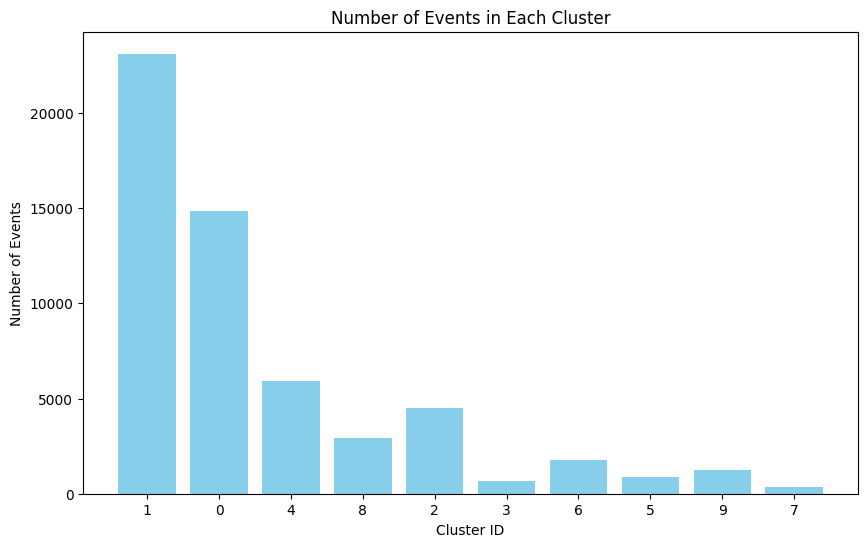

In [44]:
import matplotlib.pyplot as plt

# Plotting the result
cluster_sizes = [len(sublog) for sublog in cluster_sublogs.values()]
plt.figure(figsize=(10, 6))
plt.bar(range(len(cluster_sublogs)), cluster_sizes, color='skyblue')
plt.xlabel('Cluster ID')
plt.ylabel('Number of Events')
plt.title('Number of Events in Each Cluster')
plt.xticks(range(len(cluster_sublogs)), labels=cluster_sublogs.keys())
plt.show()

Finally split the modified log by cluster label and save each sublog to a csv file, so that each one can be handled as standalone eventlog

In [45]:
import os

base_dir = "base_approach"
os.makedirs(base_dir, exist_ok=True)

cluster_sublogs = {k: cluster_sublogs[k] for k in sorted(cluster_sublogs)}
for cluster_label, df in cluster_sublogs.items():
    file_path = os.path.join(base_dir, f"cluster_{cluster_label}.csv")
    df.to_csv(file_path,sep=';',index=False)

print(f"Clusters exported to /base_approach")

Clusters exported to /base_approach


## Visualization of Sublogs

To visualize our result, we use pm4py alpha miner and own vizualizer implementation to visualize created sub models

replaying log with TBR, completed traces ::   0%|          | 0/3 [00:00<?, ?it/s]

replaying log with TBR, completed traces ::   0%|          | 0/13 [00:00<?, ?it/s]

replaying log with TBR, completed traces ::   0%|          | 0/3 [00:00<?, ?it/s]

14858 events, 2476 cases


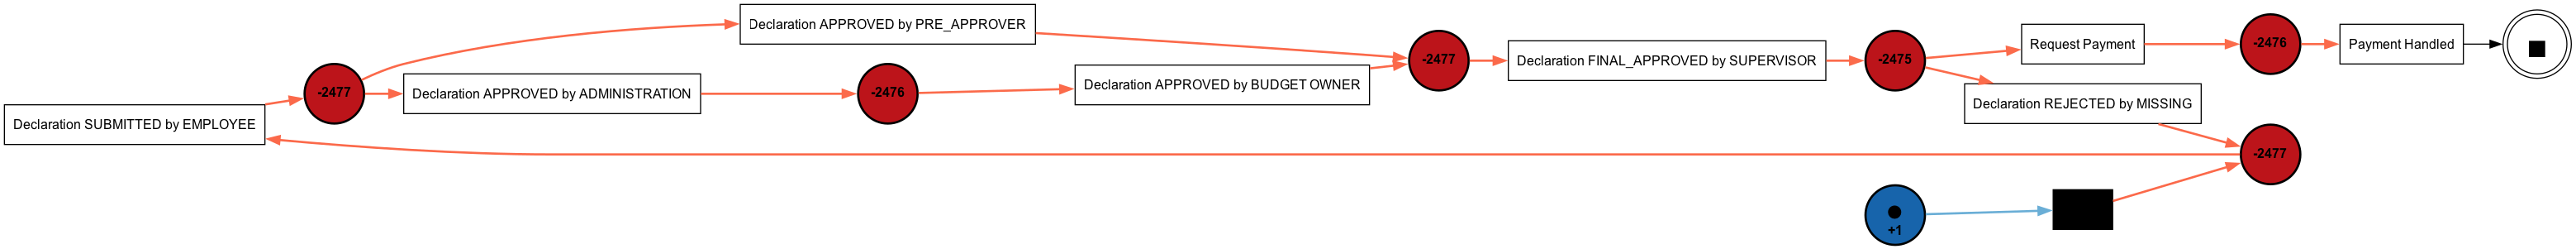

replaying log with TBR, completed traces ::   0%|          | 0/3 [00:00<?, ?it/s]

replaying log with TBR, completed traces ::   0%|          | 0/10 [00:00<?, ?it/s]

replaying log with TBR, completed traces ::   0%|          | 0/3 [00:00<?, ?it/s]

23114 events, 4623 cases


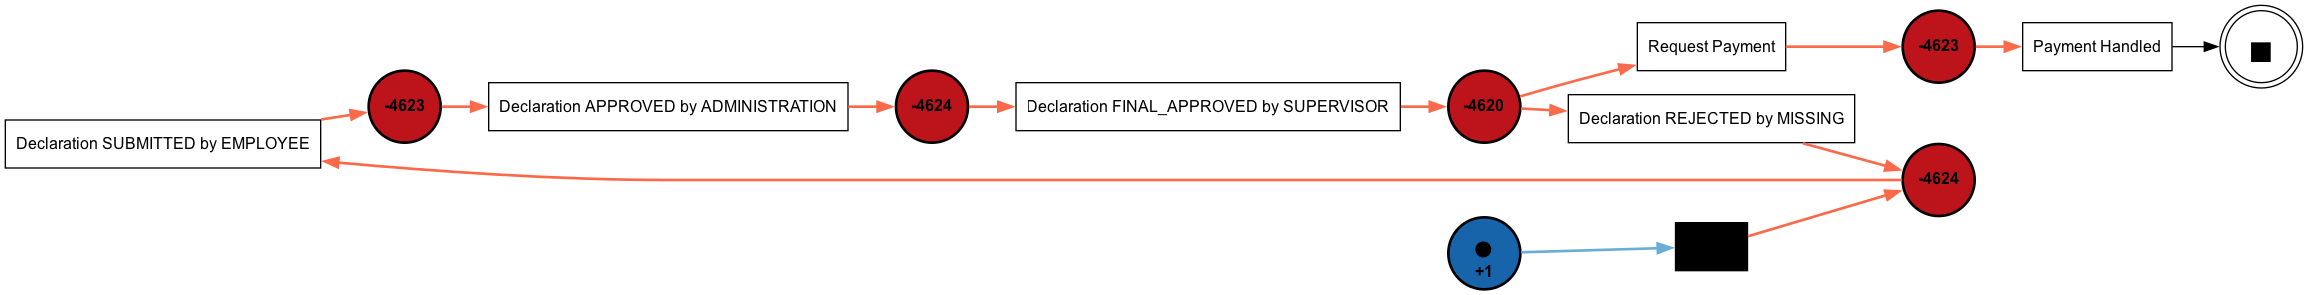

replaying log with TBR, completed traces ::   0%|          | 0/5 [00:00<?, ?it/s]

replaying log with TBR, completed traces ::   0%|          | 0/28 [00:00<?, ?it/s]

replaying log with TBR, completed traces ::   0%|          | 0/5 [00:00<?, ?it/s]

4491 events, 537 cases


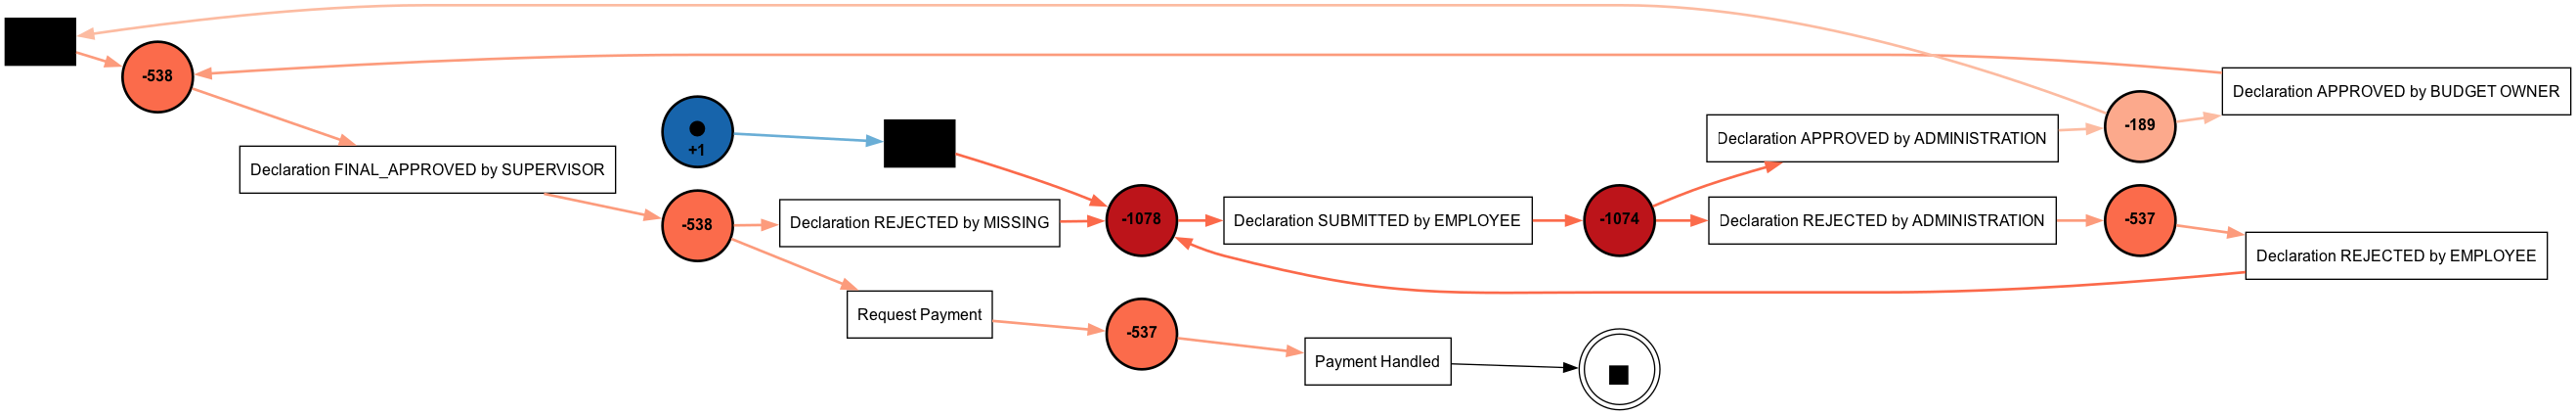

replaying log with TBR, completed traces ::   0%|          | 0/9 [00:00<?, ?it/s]

replaying log with TBR, completed traces ::   0%|          | 0/17 [00:00<?, ?it/s]

replaying log with TBR, completed traces ::   0%|          | 0/9 [00:00<?, ?it/s]

673 events, 207 cases


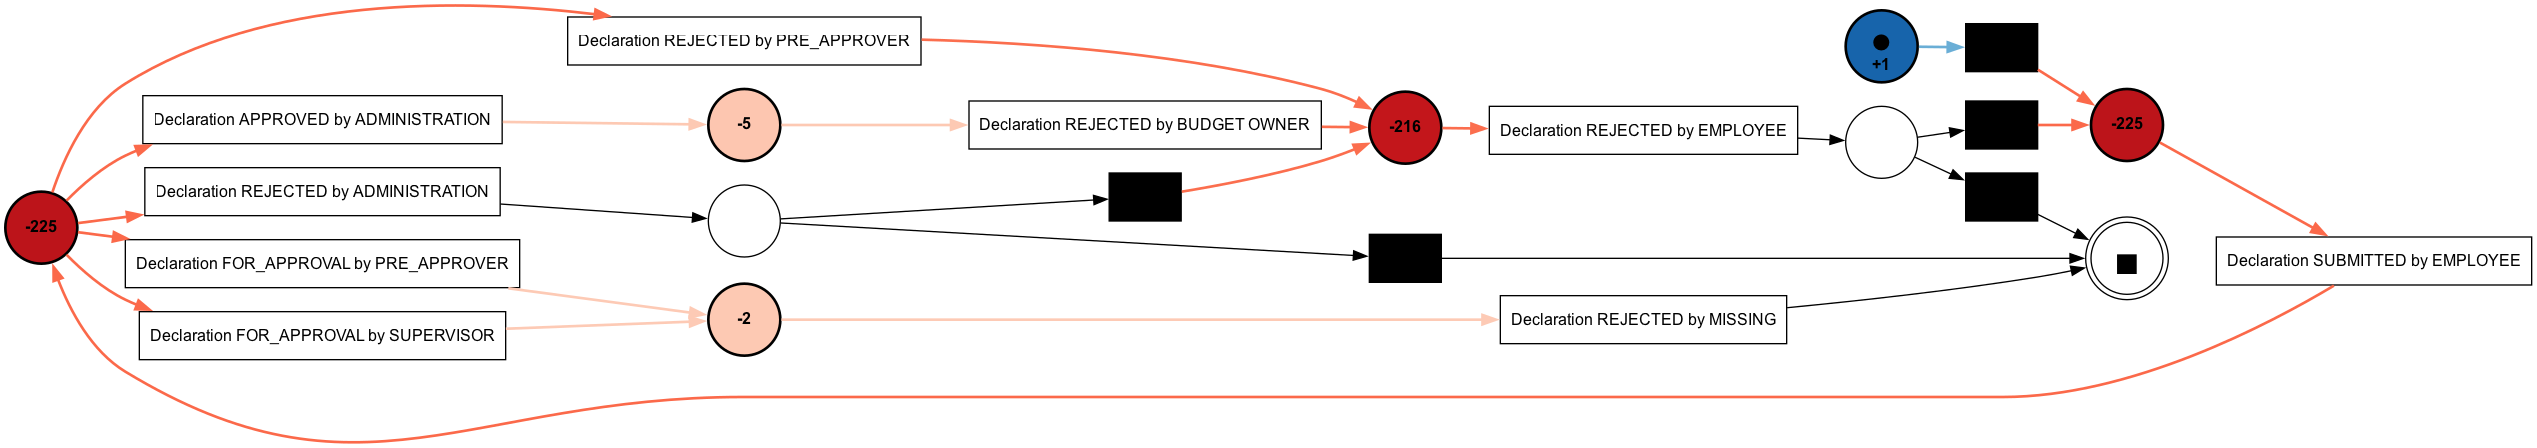

replaying log with TBR, completed traces ::   0%|          | 0/6 [00:00<?, ?it/s]

replaying log with TBR, completed traces ::   0%|          | 0/9 [00:00<?, ?it/s]

replaying log with TBR, completed traces ::   0%|          | 0/6 [00:00<?, ?it/s]

5932 events, 1458 cases


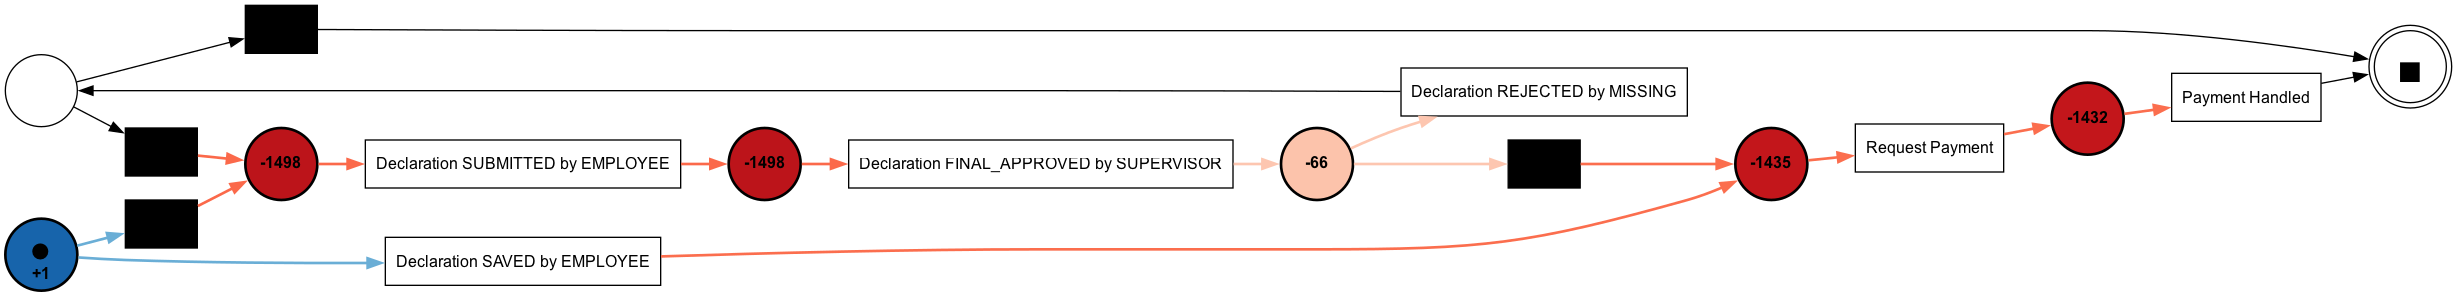

replaying log with TBR, completed traces ::   0%|          | 0/16 [00:00<?, ?it/s]

replaying log with TBR, completed traces ::   0%|          | 0/85 [00:00<?, ?it/s]

replaying log with TBR, completed traces ::   0%|          | 0/16 [00:00<?, ?it/s]

904 events, 110 cases


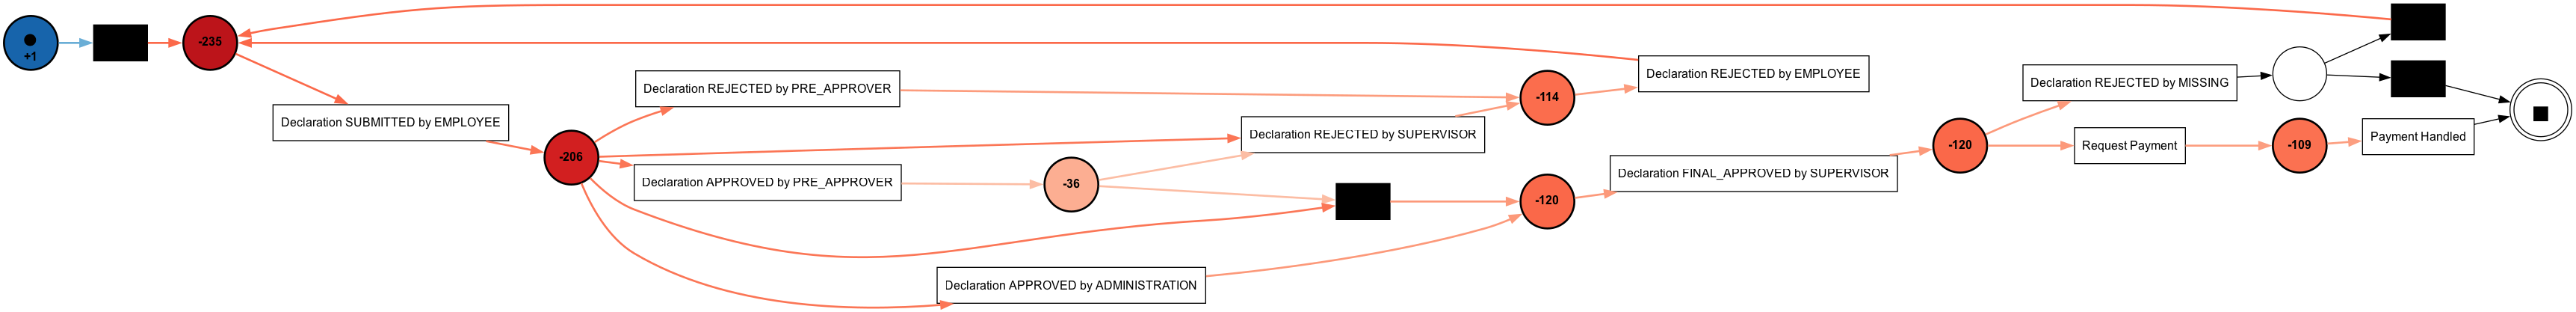

replaying log with TBR, completed traces ::   0%|          | 0/13 [00:00<?, ?it/s]

replaying log with TBR, completed traces ::   0%|          | 0/70 [00:00<?, ?it/s]

replaying log with TBR, completed traces ::   0%|          | 0/13 [00:00<?, ?it/s]

1776 events, 184 cases


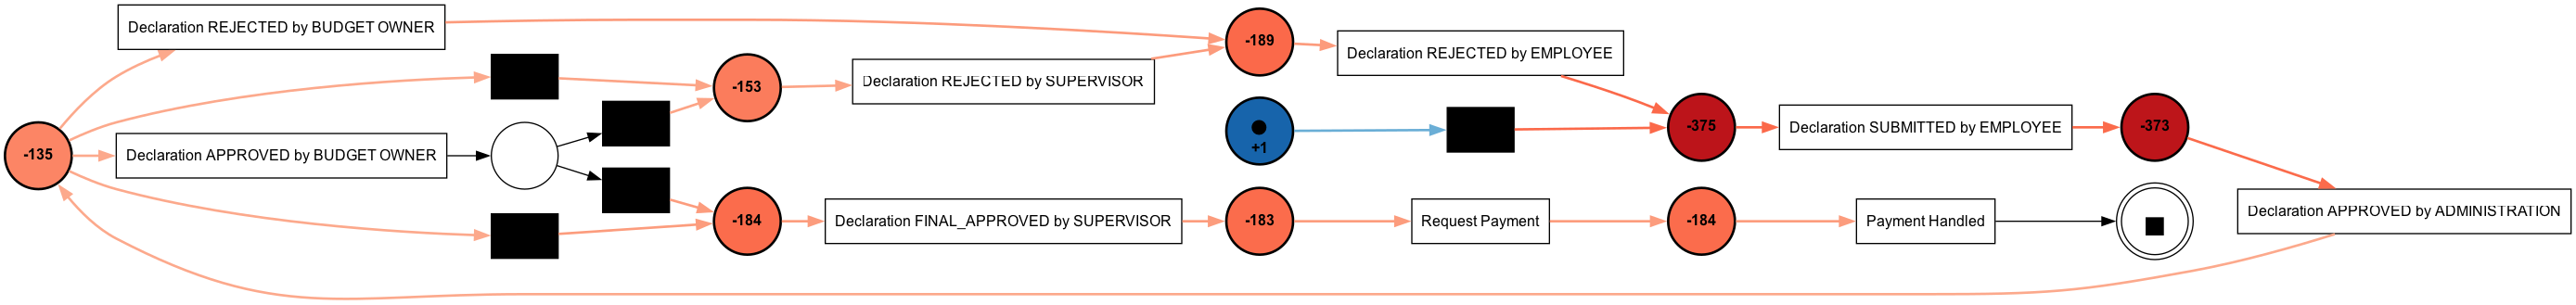

replaying log with TBR, completed traces ::   0%|          | 0/17 [00:00<?, ?it/s]

replaying log with TBR, completed traces ::   0%|          | 0/34 [00:00<?, ?it/s]

replaying log with TBR, completed traces ::   0%|          | 0/17 [00:00<?, ?it/s]

377 events, 85 cases


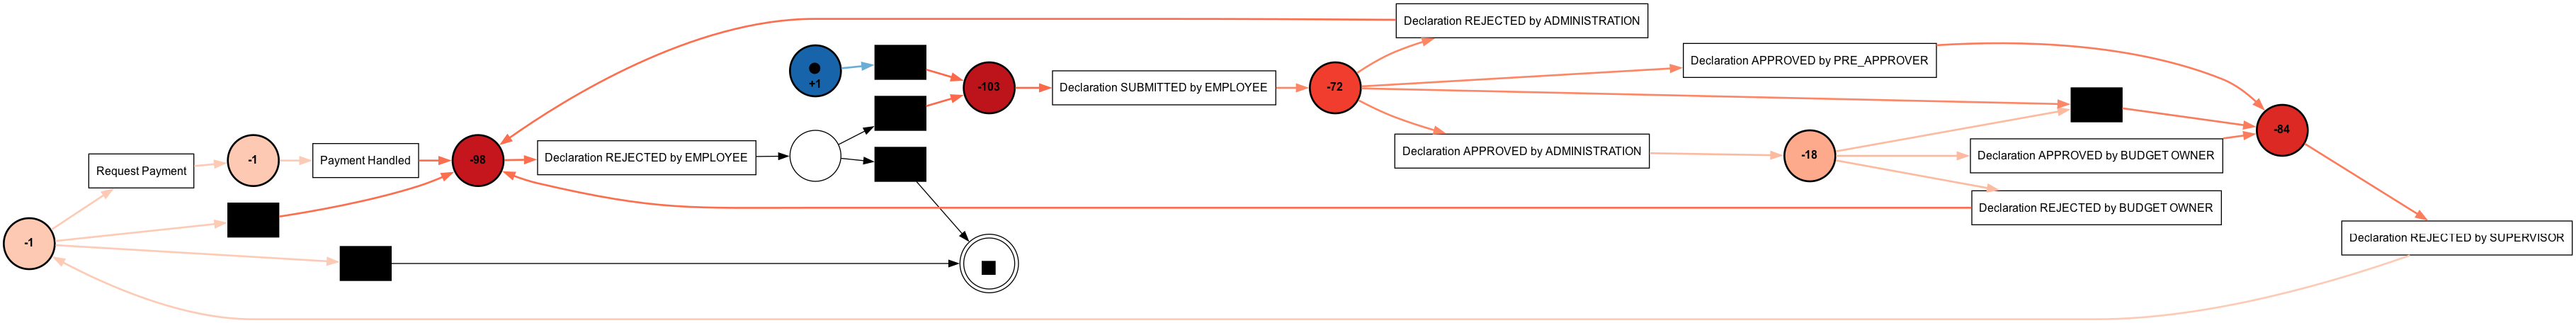

replaying log with TBR, completed traces ::   0%|          | 0/3 [00:00<?, ?it/s]

replaying log with TBR, completed traces ::   0%|          | 0/9 [00:00<?, ?it/s]

replaying log with TBR, completed traces ::   0%|          | 0/3 [00:00<?, ?it/s]

2946 events, 584 cases


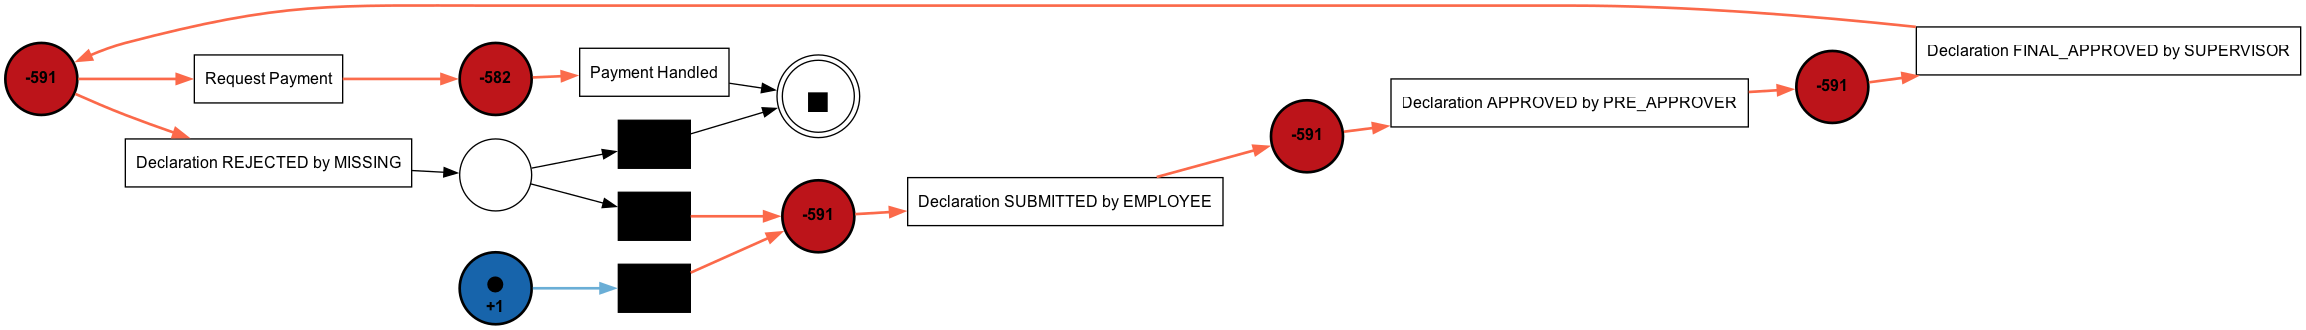

replaying log with TBR, completed traces ::   0%|          | 0/23 [00:00<?, ?it/s]

replaying log with TBR, completed traces ::   0%|          | 0/144 [00:00<?, ?it/s]

replaying log with TBR, completed traces ::   0%|          | 0/23 [00:00<?, ?it/s]

1232 events, 102 cases


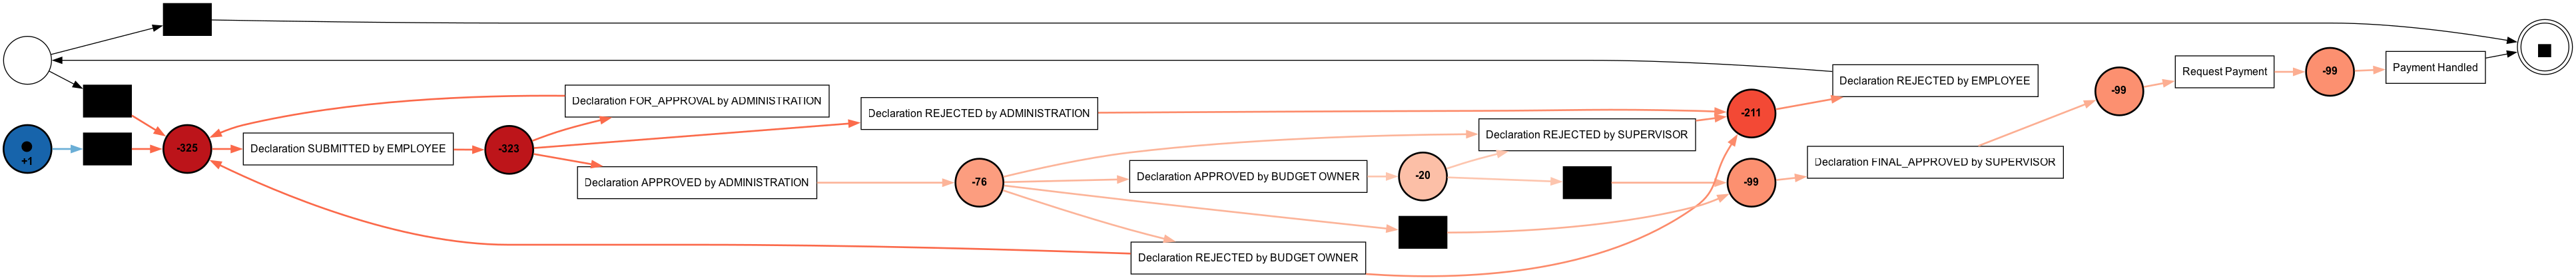

In [46]:
from practical.ProcessMining.group1.shared.visualizer import Visualizer
from practical.ProcessMining.group1.task4.tokenreplay import TokenReplay

def visualize_single_log(_cluster, df):
    _event_log = log_converter.to_event_log.apply(df)
    
    net, init, final = heuristics_miner.apply(_event_log)

    heuristics_miner_replay = TokenReplay(_event_log, net, init, final, "Heuristic Miner")

    heuristics_miner_replay.run(_event_log)  # alpha_token_replay.shuffle_activities()
    tokens = heuristics_miner_replay.get_unconformity_tokens()

    vizard = Visualizer()
    graph = vizard.build_petri_net(net, init, final, tokens)
    print(f'{df.shape[0]} events, {df["case:concept:name"].unique().shape[0]} cases')

    vizard.display(graph)

def visualize_sublogs(_cluster_sublogs):
    for cluster_label, df in _cluster_sublogs.items():
        visualize_single_log(cluster_label, df)

visualize_sublogs(cluster_sublogs)

## Direct Log Version Comparison

In [47]:
step0 = []
for log in LOG_VERSIONS:
    event_log_sampled = event_log_preprocessed.sample(n=1000)
    traces = get_df_by_traces(event_log_sampled)
    encoded_log = hot_encode_traces(log, traces)
    step0.append({"sample": event_log_sampled, "encoded": encoded_log, "traces": traces})

step1 = []
for i, log in enumerate(LOG_VERSIONS):
    best_params = param_grid_tuning(sample_log=step0[i]["sample"], _encoded_log=step0[i]["encoded"])
    step1.append(best_params)

step2 = []
for i, log in enumerate(LOG_VERSIONS):
    event_log, cluster_labels = apply_kmeans(params=step1[i], _event_log=log, _traces=step0[i]["traces"])
    step2.append({"event_log": event_log, "cluster": cluster_labels})
    
step3 = []
for i, log in enumerate(LOG_VERSIONS):
    cluster_sublogs = split_by_cluster(_event_log=step2[i]["event_log"])
    step3.append(cluster_sublogs)

aligning log, completed variants :: 100%|██████████| 39/39 [00:00<00:00, 131.50it/s]
computing precision with alignments, completed variants :: 100%|██████████| 11/11 [00:00<00:00, 418.30it/s]
aligning log, completed variants :: 100%|██████████| 39/39 [00:00<00:00, 120.38it/s]
computing precision with alignments, completed variants :: 100%|██████████| 11/11 [00:00<00:00, 386.24it/s]
computing precision with alignments, completed variants :: 100%|██████████| 11/11 [00:00<00:00, 47.45it/s]
computing precision with alignments, completed variants :: 100%|██████████| 11/11 [00:00<00:00, 46.29it/s]
computing precision with alignments, completed variants :: 100%|██████████| 11/11 [00:00<00:00, 47.28it/s]
computing precision with alignments, completed variants :: 100%|██████████| 11/11 [00:00<00:00, 45.27it/s]
aligning log, completed variants :: 100%|██████████| 39/39 [00:00<00:00, 143.57it/s]
computing precision with alignments, completed variants :: 100%|██████████| 11/11 [00:00<00:00, 287.4

Best Score: 0.9623015153411969
Best Params: {'init': 'k-means++', 'max_iter': 100, 'n_clusters': 10, 'n_init': 10}


aligning log, completed variants :: 100%|██████████| 39/39 [00:00<00:00, 179.45it/s]
computing precision with alignments, completed variants :: 100%|██████████| 10/10 [00:00<00:00, 501.79it/s]
computing precision with alignments, completed variants :: 100%|██████████| 10/10 [00:00<00:00, 487.78it/s]
computing precision with alignments, completed variants :: 100%|██████████| 10/10 [00:00<00:00, 459.20it/s]
aligning log, completed variants :: 100%|██████████| 39/39 [00:00<00:00, 167.42it/s]
computing precision with alignments, completed variants :: 100%|██████████| 10/10 [00:00<00:00, 403.34it/s]
aligning log, completed variants :: 100%|██████████| 39/39 [00:00<00:00, 155.83it/s]
computing precision with alignments, completed variants :: 100%|██████████| 10/10 [00:00<00:00, 574.18it/s]
computing precision with alignments, completed variants :: 100%|██████████| 10/10 [00:00<00:00, 530.82it/s]
aligning log, completed variants :: 100%|██████████| 39/39 [00:00<00:00, 142.39it/s]
computing pr

Best Score: 0.9839961861563405
Best Params: {'init': 'k-means++', 'max_iter': 100, 'n_clusters': 10, 'n_init': 10}


aligning log, completed variants :: 100%|██████████| 40/40 [00:00<00:00, 274.72it/s]
computing precision with alignments, completed variants :: 100%|██████████| 8/8 [00:00<00:00, 613.39it/s]
aligning log, completed variants :: 100%|██████████| 40/40 [00:00<00:00, 275.89it/s]
computing precision with alignments, completed variants :: 100%|██████████| 8/8 [00:00<00:00, 637.81it/s]
computing precision with alignments, completed variants :: 100%|██████████| 8/8 [00:00<00:00, 751.50it/s]
computing precision with alignments, completed variants :: 100%|██████████| 8/8 [00:00<00:00, 699.78it/s]
aligning log, completed variants :: 100%|██████████| 40/40 [00:00<00:00, 224.47it/s]00<?, ?it/s]
computing precision with alignments, completed variants :: 100%|██████████| 8/8 [00:00<00:00, 558.81it/s]
computing precision with alignments, completed variants :: 100%|██████████| 8/8 [00:00<00:00, 398.90it/s]
aligning log, completed variants :: 100%|██████████| 40/40 [00:00<00:00, 209.81it/s]00<?, ?it/s]


Best Score: 0.9617174223004151
Best Params: {'init': 'k-means++', 'max_iter': 100, 'n_clusters': 10, 'n_init': 10}


Version: full span - Cluster: 0


replaying log with TBR, completed traces ::   0%|          | 0/3 [00:00<?, ?it/s]

replaying log with TBR, completed traces ::   0%|          | 0/10 [00:00<?, ?it/s]

replaying log with TBR, completed traces ::   0%|          | 0/3 [00:00<?, ?it/s]

23114 events, 4623 cases


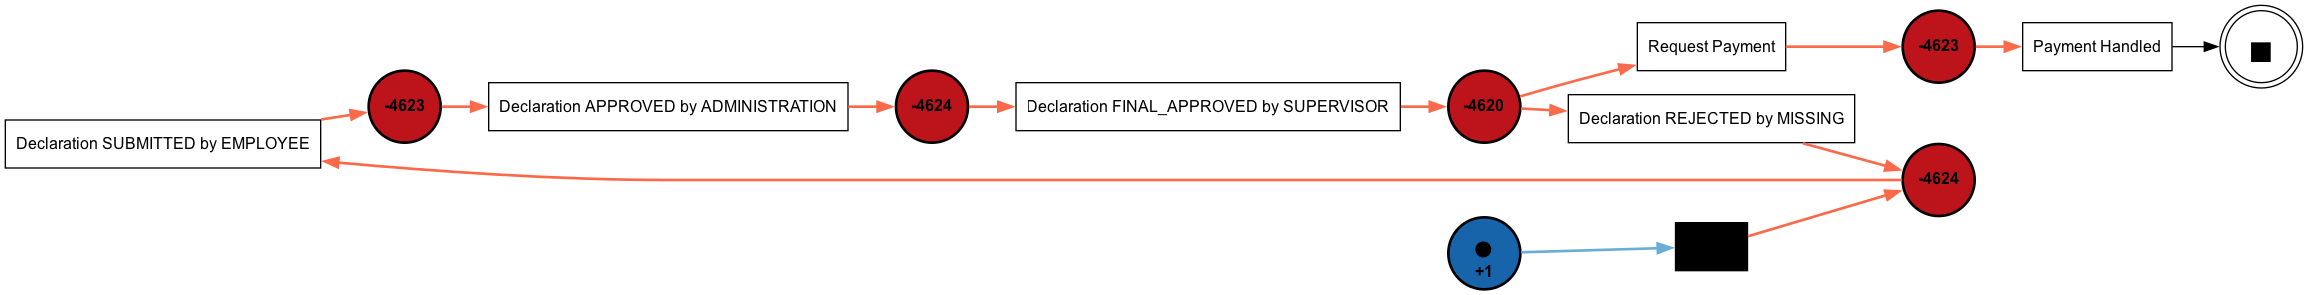

Version: from 2018 - Cluster: 0


replaying log with TBR, completed traces ::   0%|          | 0/2 [00:00<?, ?it/s]

replaying log with TBR, completed traces ::   0%|          | 0/5 [00:00<?, ?it/s]

replaying log with TBR, completed traces ::   0%|          | 0/2 [00:00<?, ?it/s]

5395 events, 1349 cases


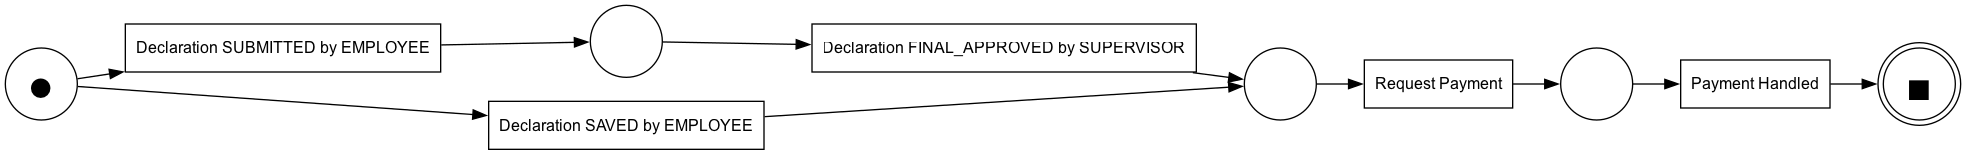

Version: before 2018 - Cluster: 0


replaying log with TBR, completed traces ::   0%|          | 0/17 [00:00<?, ?it/s]

replaying log with TBR, completed traces ::   0%|          | 0/127 [00:00<?, ?it/s]

replaying log with TBR, completed traces ::   0%|          | 0/17 [00:00<?, ?it/s]

398 events, 29 cases


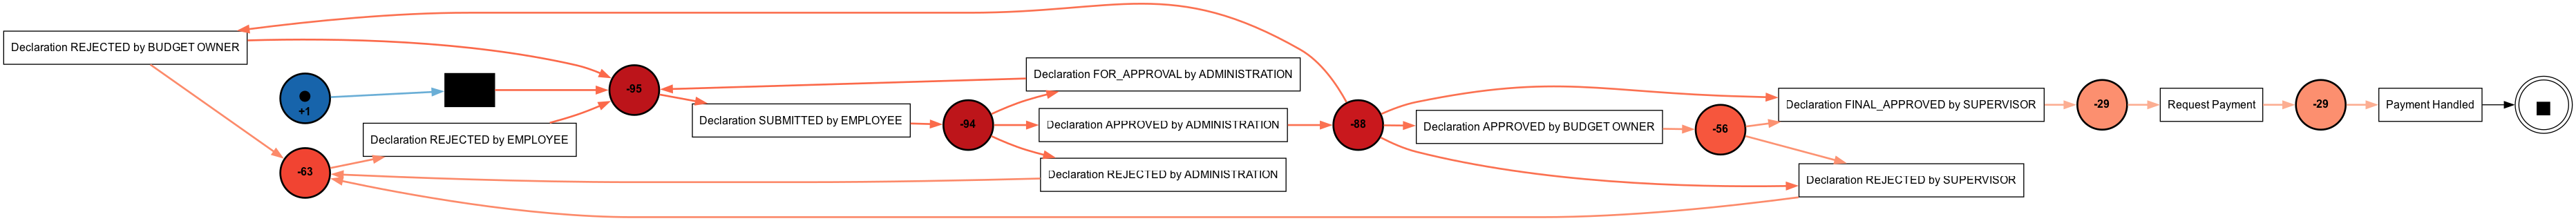








Version: full span - Cluster: 1


replaying log with TBR, completed traces ::   0%|          | 0/2 [00:00<?, ?it/s]

replaying log with TBR, completed traces ::   0%|          | 0/15 [00:00<?, ?it/s]

replaying log with TBR, completed traces ::   0%|          | 0/2 [00:00<?, ?it/s]

1702 events, 189 cases


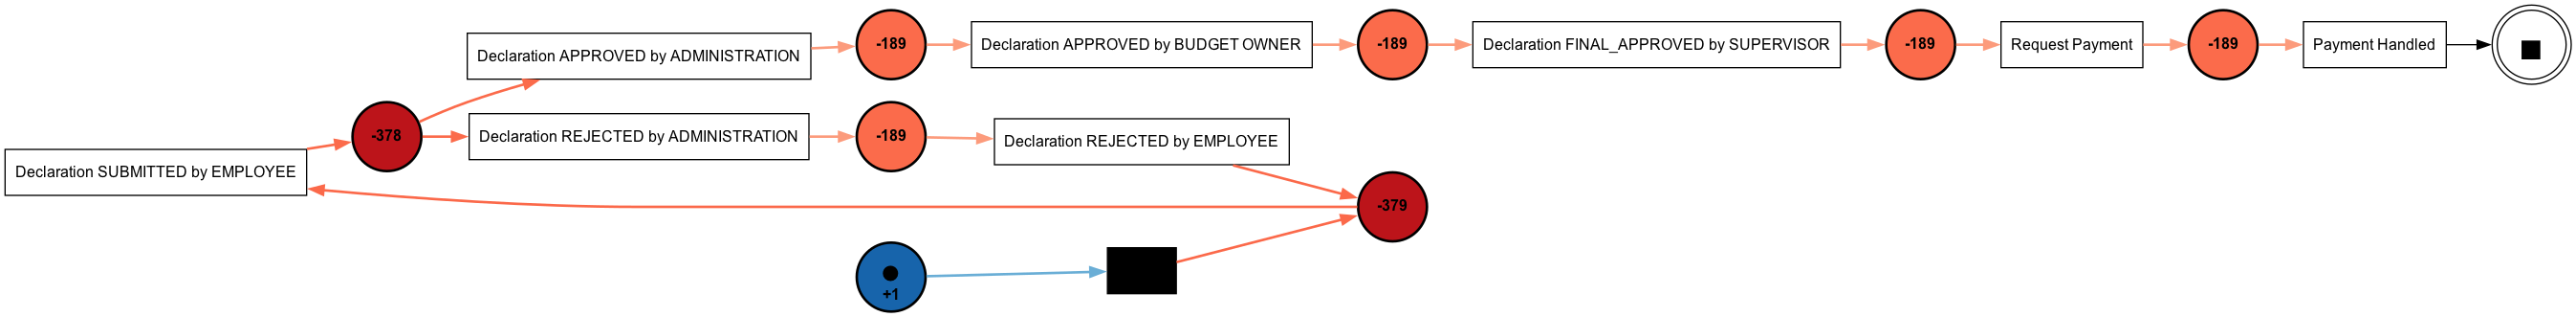

Version: from 2018 - Cluster: 1


replaying log with TBR, completed traces ::   0%|          | 0/4 [00:00<?, ?it/s]

2815 events, 563 cases


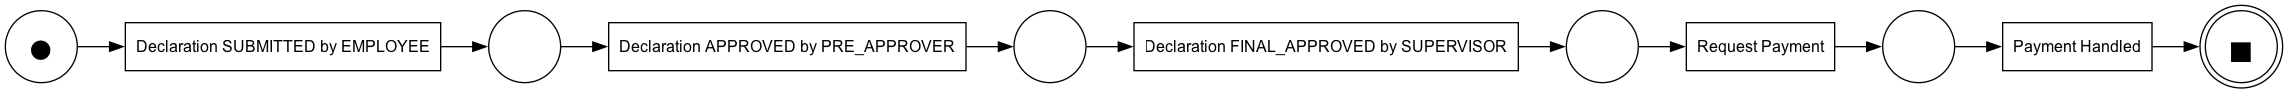

Version: before 2018 - Cluster: 1


replaying log with TBR, completed traces ::   0%|          | 0/5 [00:00<?, ?it/s]

replaying log with TBR, completed traces ::   0%|          | 0/13 [00:00<?, ?it/s]

replaying log with TBR, completed traces ::   0%|          | 0/5 [00:00<?, ?it/s]

23153 events, 4643 cases


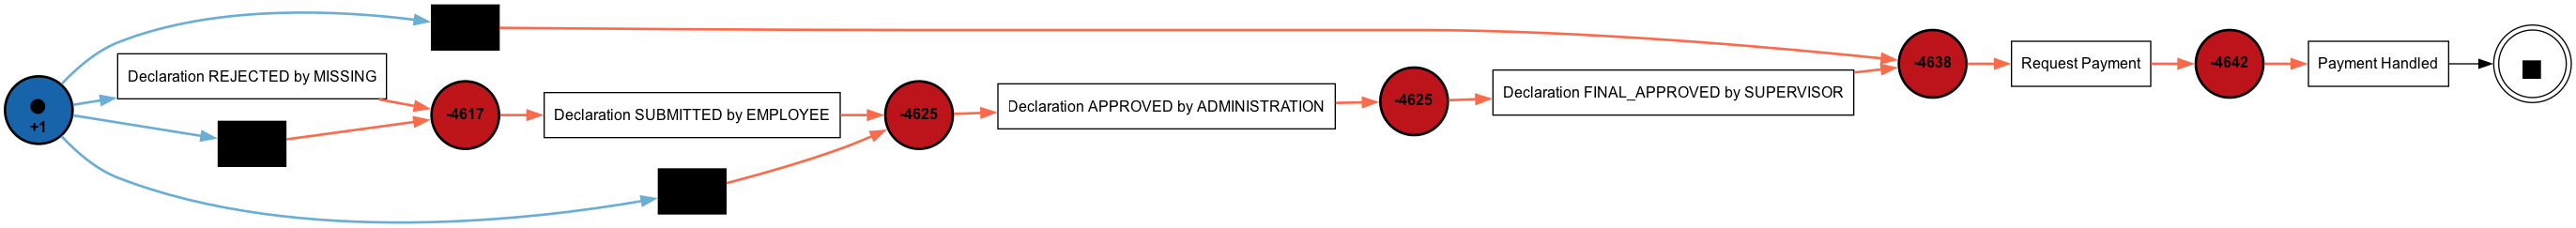








Version: full span - Cluster: 2


replaying log with TBR, completed traces ::   0%|          | 0/3 [00:00<?, ?it/s]

replaying log with TBR, completed traces ::   0%|          | 0/13 [00:00<?, ?it/s]

replaying log with TBR, completed traces ::   0%|          | 0/3 [00:00<?, ?it/s]

14858 events, 2476 cases


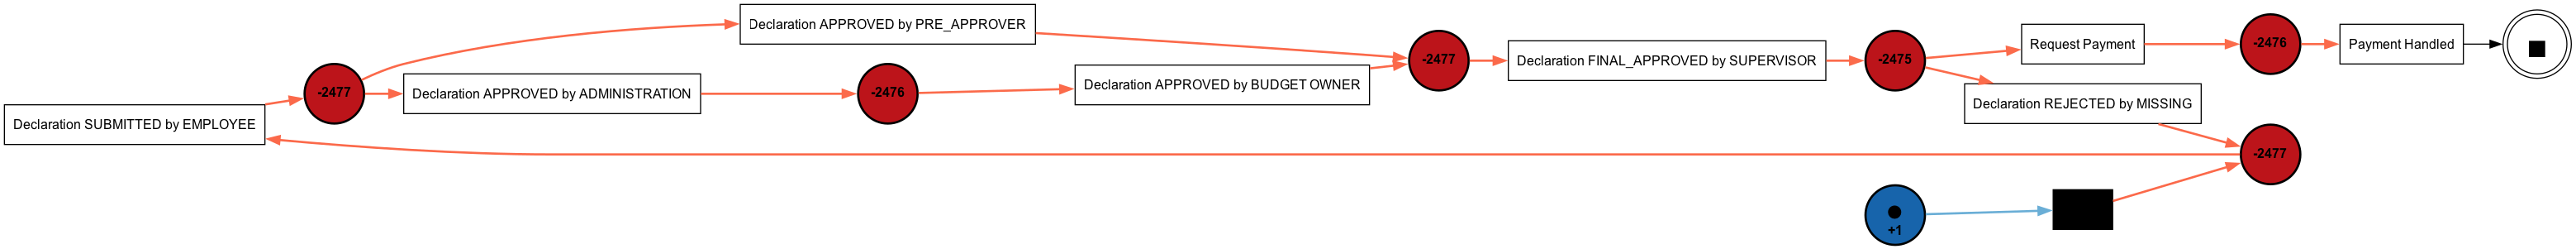

Version: from 2018 - Cluster: 2


replaying log with TBR, completed traces ::   0%|          | 0/7 [00:00<?, ?it/s]

replaying log with TBR, completed traces ::   0%|          | 0/21 [00:00<?, ?it/s]

replaying log with TBR, completed traces ::   0%|          | 0/7 [00:00<?, ?it/s]

552 events, 68 cases


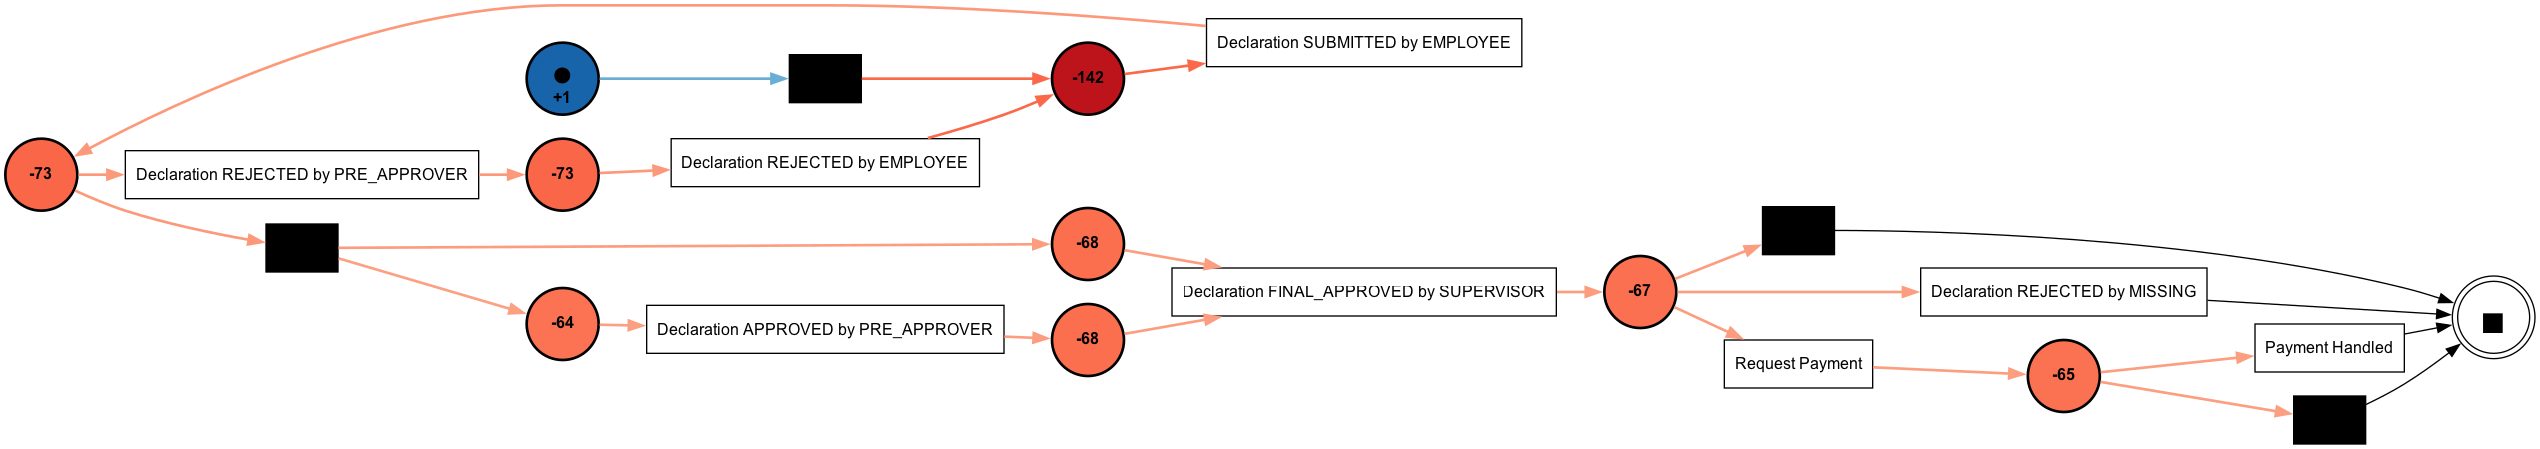

Version: before 2018 - Cluster: 2


replaying log with TBR, completed traces ::   0%|          | 0/4 [00:00<?, ?it/s]

replaying log with TBR, completed traces ::   0%|          | 0/15 [00:00<?, ?it/s]

replaying log with TBR, completed traces ::   0%|          | 0/4 [00:00<?, ?it/s]

14854 events, 2476 cases


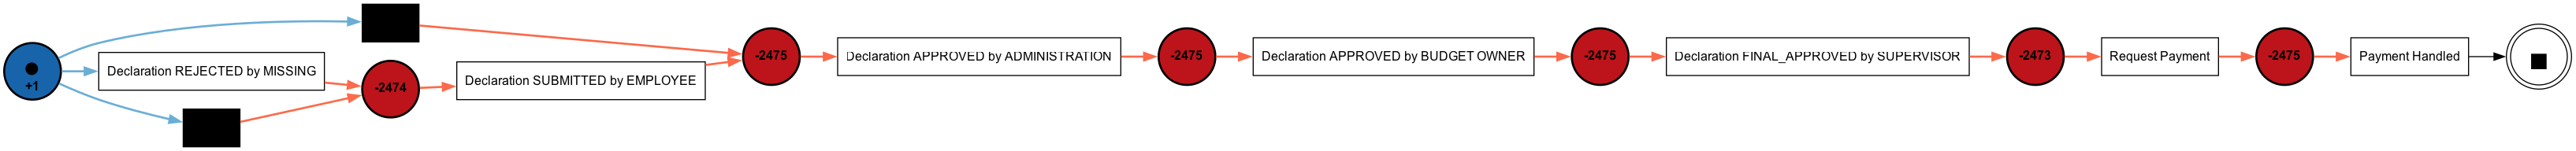








Version: full span - Cluster: 3


replaying log with TBR, completed traces ::   0%|          | 0/7 [00:00<?, ?it/s]

replaying log with TBR, completed traces ::   0%|          | 0/12 [00:00<?, ?it/s]

replaying log with TBR, completed traces ::   0%|          | 0/7 [00:00<?, ?it/s]

5937 events, 1459 cases


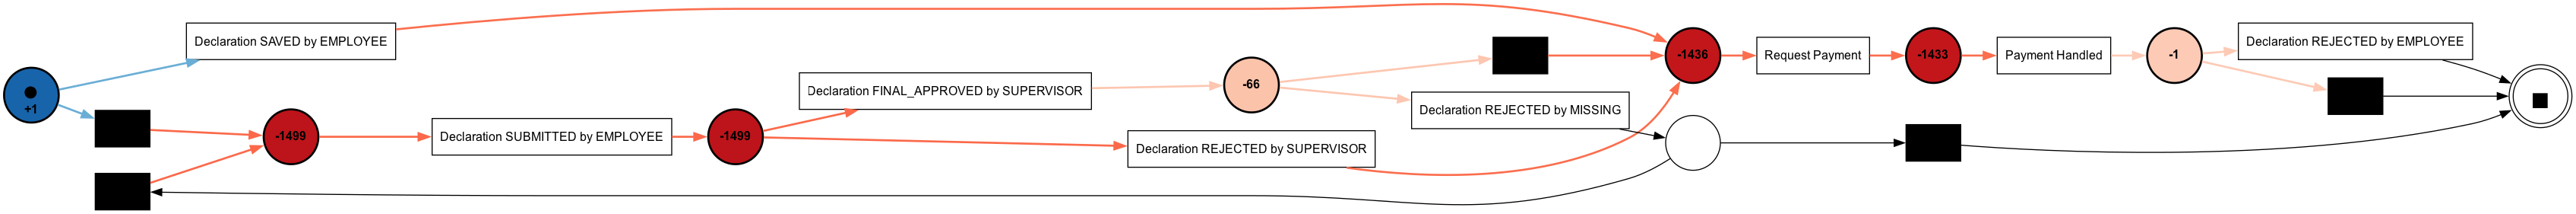

Version: from 2018 - Cluster: 3


replaying log with TBR, completed traces ::   0%|          | 0/7 [00:00<?, ?it/s]

replaying log with TBR, completed traces ::   0%|          | 0/10 [00:00<?, ?it/s]

replaying log with TBR, completed traces ::   0%|          | 0/7 [00:00<?, ?it/s]

135 events, 39 cases


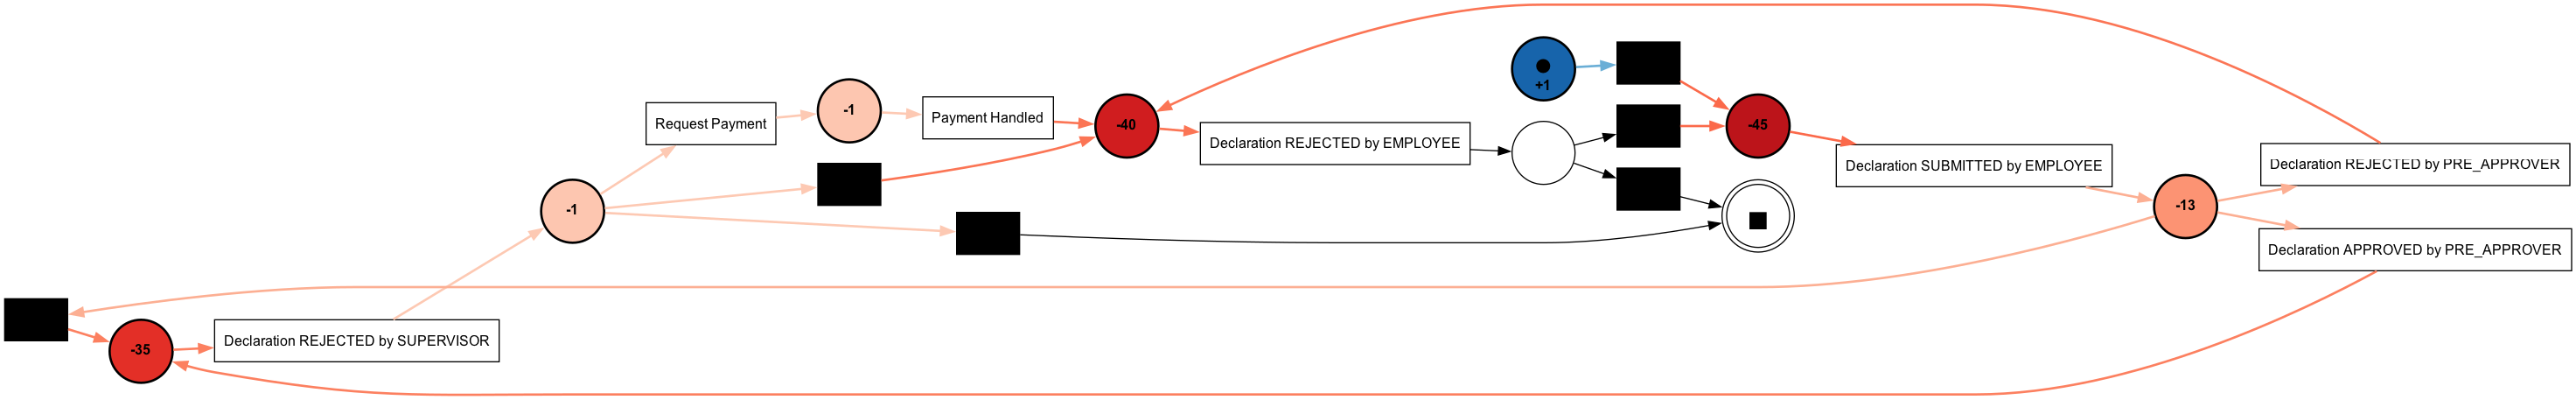

Version: before 2018 - Cluster: 3


replaying log with TBR, completed traces ::   0%|          | 0/4 [00:00<?, ?it/s]

replaying log with TBR, completed traces ::   0%|          | 0/27 [00:00<?, ?it/s]

replaying log with TBR, completed traces ::   0%|          | 0/4 [00:00<?, ?it/s]

2786 events, 348 cases


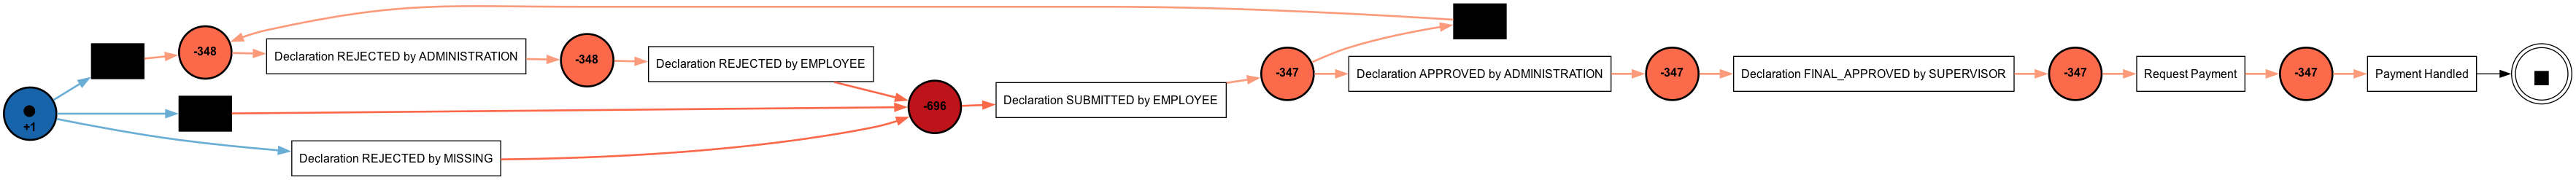








Version: full span - Cluster: 4


replaying log with TBR, completed traces ::   0%|          | 0/23 [00:00<?, ?it/s]

replaying log with TBR, completed traces ::   0%|          | 0/37 [00:00<?, ?it/s]

replaying log with TBR, completed traces ::   0%|          | 0/23 [00:00<?, ?it/s]

1028 events, 289 cases


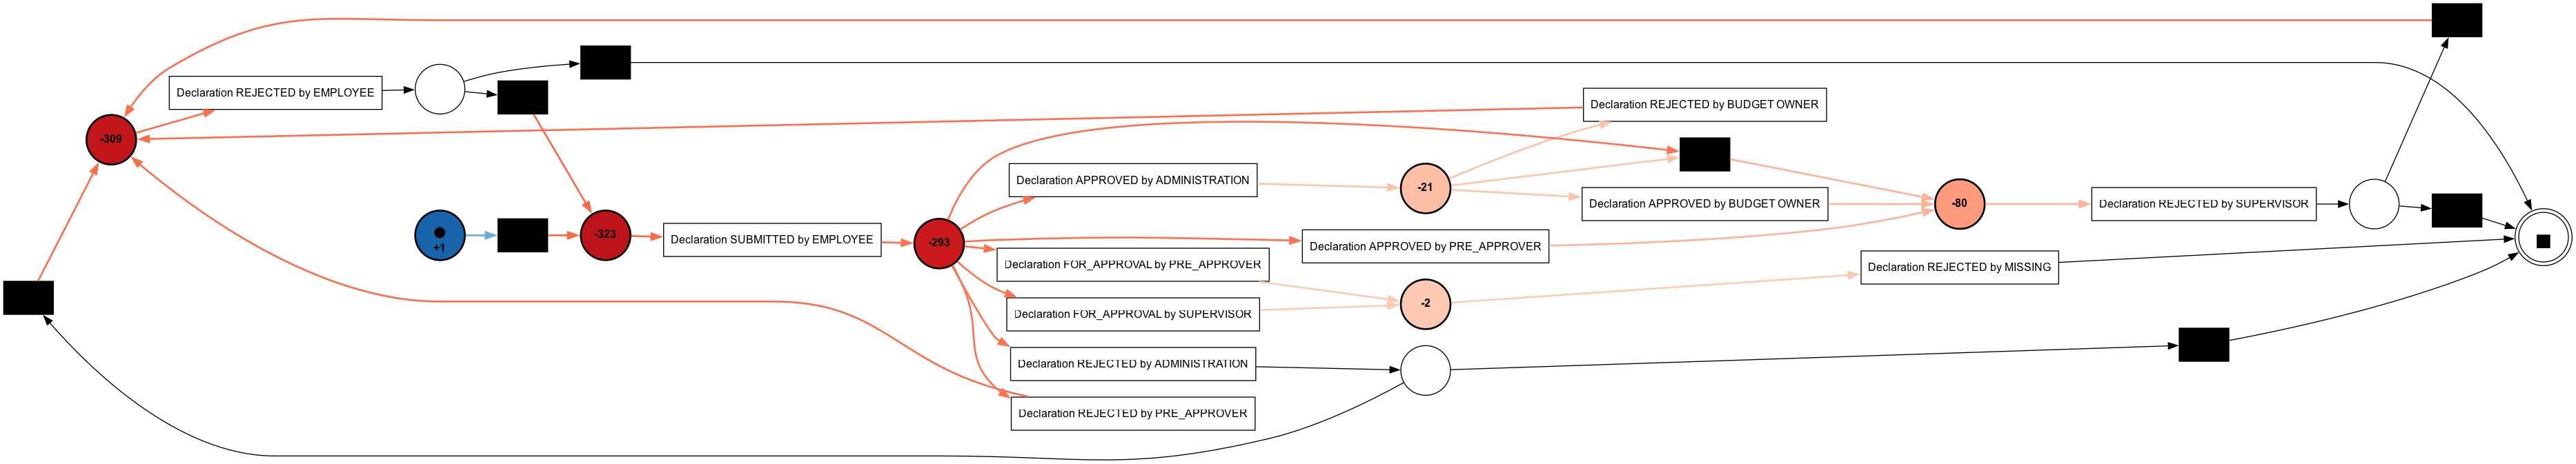

Version: from 2018 - Cluster: 4


replaying log with TBR, completed traces ::   0%|          | 0/6 [00:00<?, ?it/s]

replaying log with TBR, completed traces ::   0%|          | 0/26 [00:00<?, ?it/s]

replaying log with TBR, completed traces ::   0%|          | 0/6 [00:00<?, ?it/s]

317 events, 44 cases


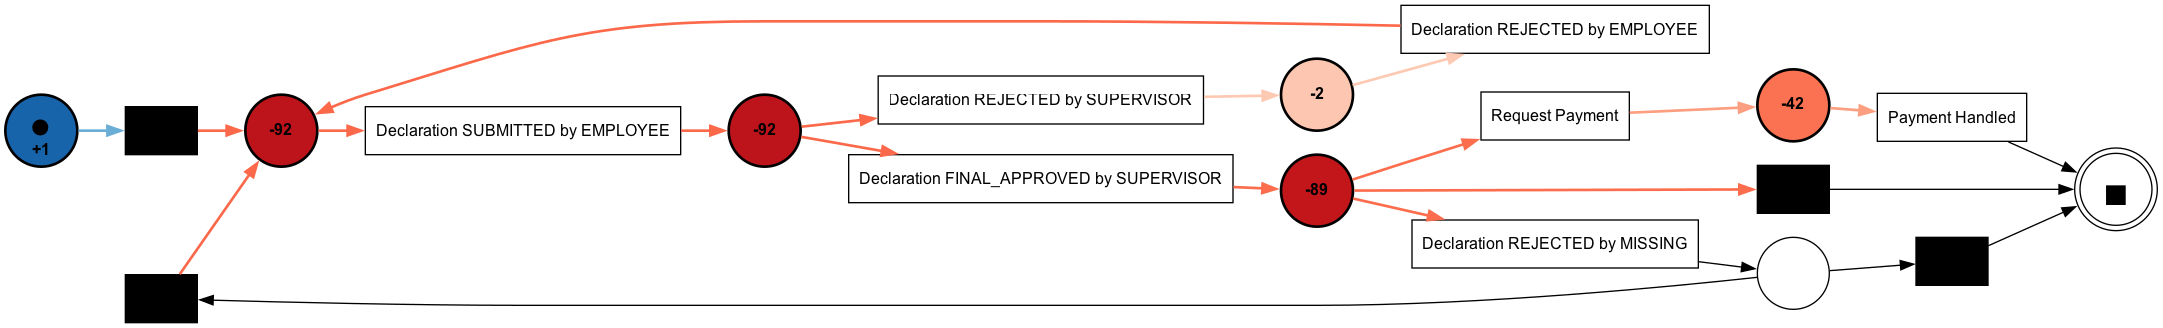

Version: before 2018 - Cluster: 4


replaying log with TBR, completed traces ::   0%|          | 0/4 [00:00<?, ?it/s]

replaying log with TBR, completed traces ::   0%|          | 0/7 [00:00<?, ?it/s]

replaying log with TBR, completed traces ::   0%|          | 0/4 [00:00<?, ?it/s]

608 events, 192 cases


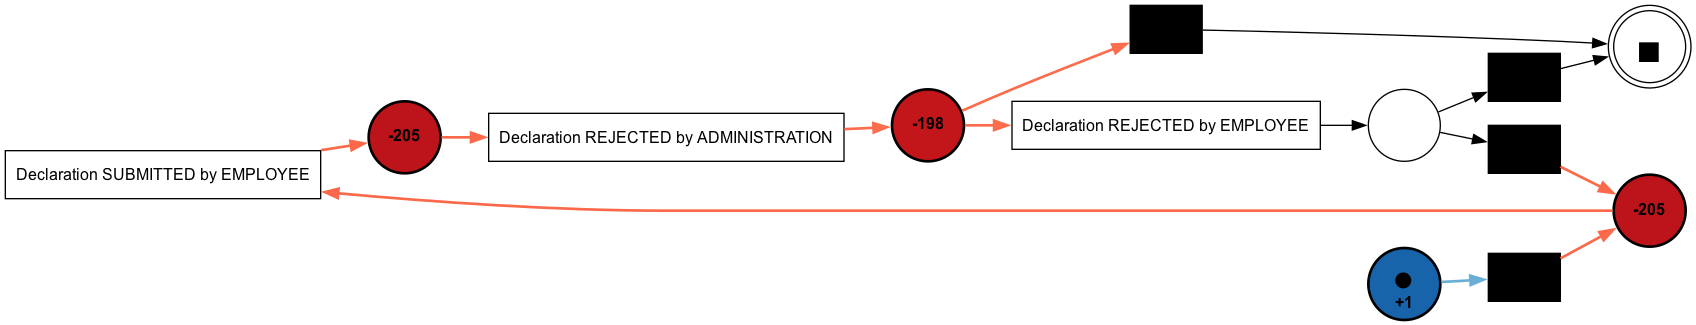








Version: full span - Cluster: 5


replaying log with TBR, completed traces ::   0%|          | 0/23 [00:00<?, ?it/s]

replaying log with TBR, completed traces ::   0%|          | 0/144 [00:00<?, ?it/s]

replaying log with TBR, completed traces ::   0%|          | 0/23 [00:00<?, ?it/s]

1232 events, 102 cases


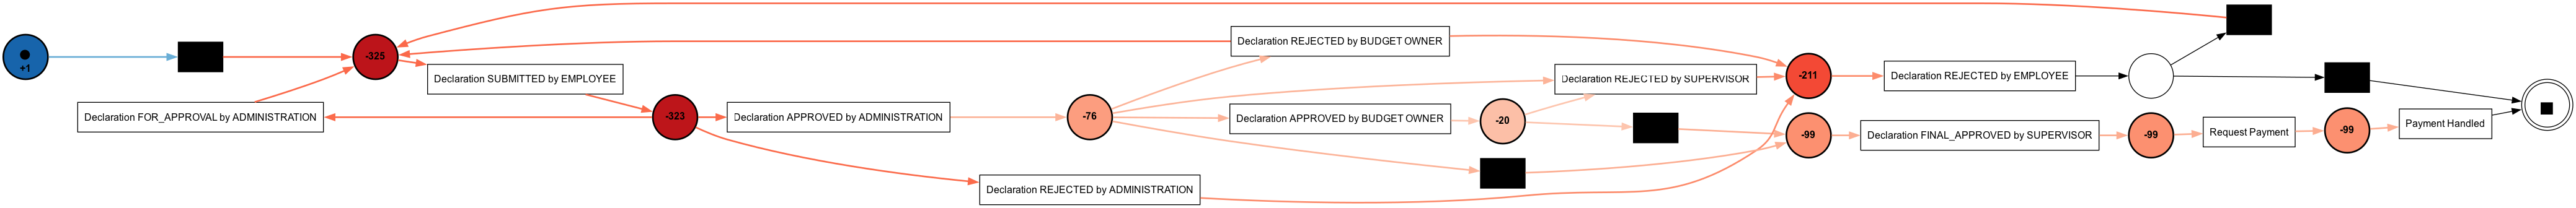

Version: from 2018 - Cluster: 5


replaying log with TBR, completed traces ::   0%|          | 0/5 [00:00<?, ?it/s]

replaying log with TBR, completed traces ::   0%|          | 0/7 [00:00<?, ?it/s]

replaying log with TBR, completed traces ::   0%|          | 0/5 [00:00<?, ?it/s]

86 events, 27 cases


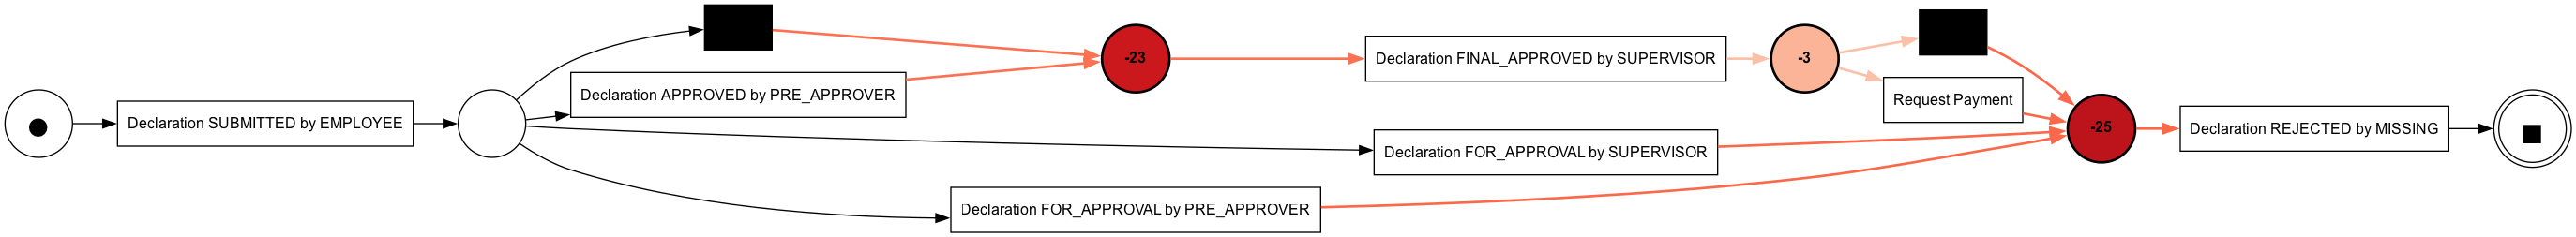

Version: before 2018 - Cluster: 5


replaying log with TBR, completed traces ::   0%|          | 0/4 [00:00<?, ?it/s]

replaying log with TBR, completed traces ::   0%|          | 0/26 [00:00<?, ?it/s]

replaying log with TBR, completed traces ::   0%|          | 0/4 [00:00<?, ?it/s]

860 events, 85 cases


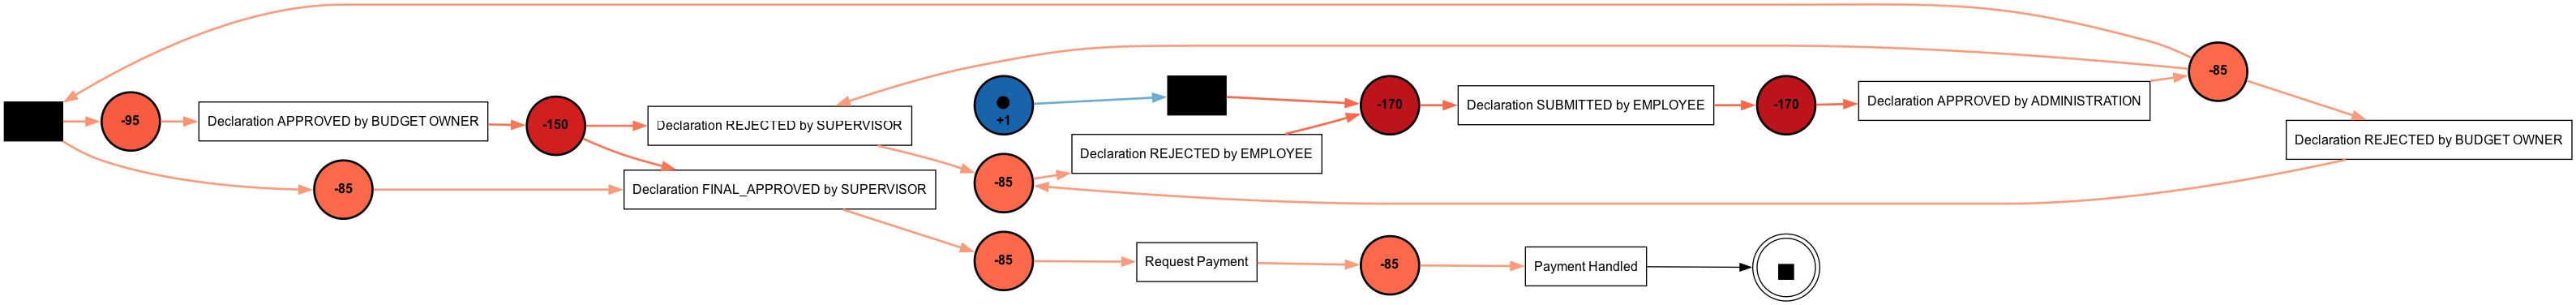








Version: full span - Cluster: 6


replaying log with TBR, completed traces ::   0%|          | 0/15 [00:00<?, ?it/s]

replaying log with TBR, completed traces ::   0%|          | 0/70 [00:00<?, ?it/s]

replaying log with TBR, completed traces ::   0%|          | 0/15 [00:00<?, ?it/s]

1793 events, 186 cases


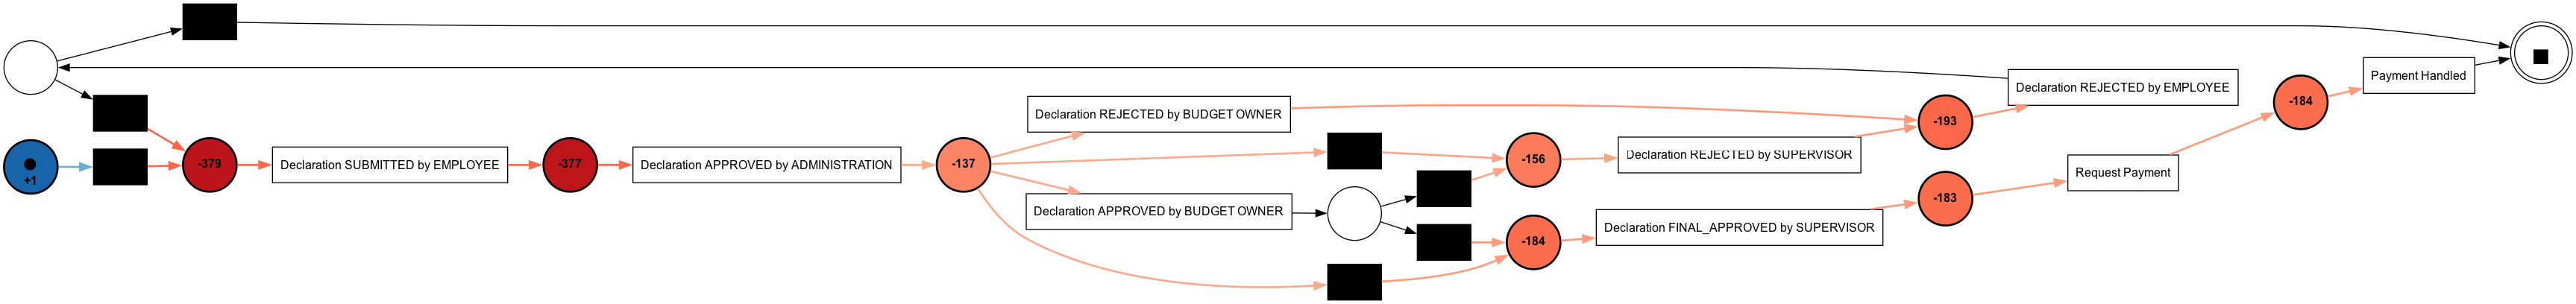

Version: from 2018 - Cluster: 6


replaying log with TBR, completed traces ::   0%|          | 0/3 [00:00<?, ?it/s]

replaying log with TBR, completed traces ::   0%|          | 0/11 [00:00<?, ?it/s]

replaying log with TBR, completed traces ::   0%|          | 0/3 [00:00<?, ?it/s]

163 events, 23 cases


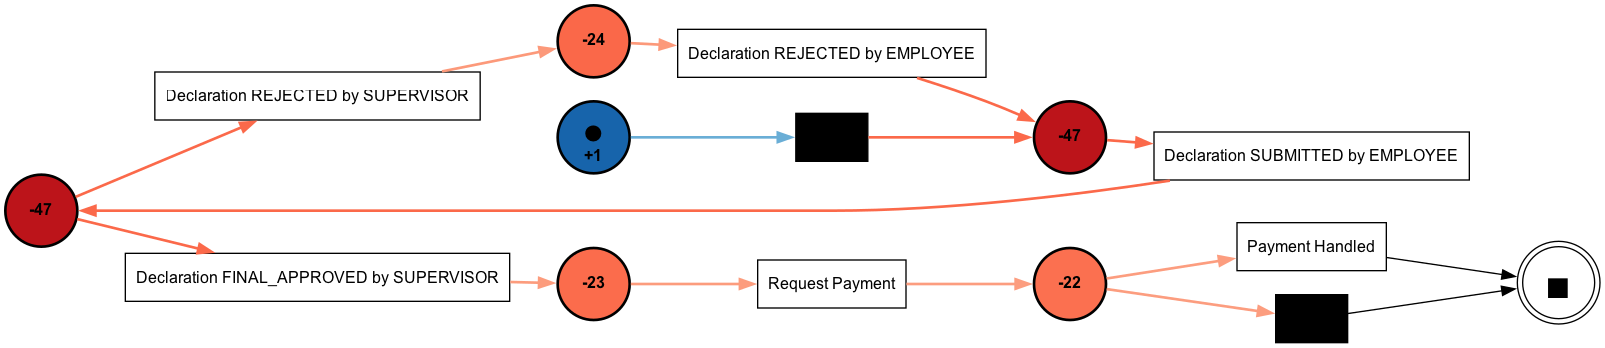

Version: before 2018 - Cluster: 6


replaying log with TBR, completed traces ::   0%|          | 0/10 [00:00<?, ?it/s]

replaying log with TBR, completed traces ::   0%|          | 0/53 [00:00<?, ?it/s]

replaying log with TBR, completed traces ::   0%|          | 0/10 [00:00<?, ?it/s]

906 events, 78 cases


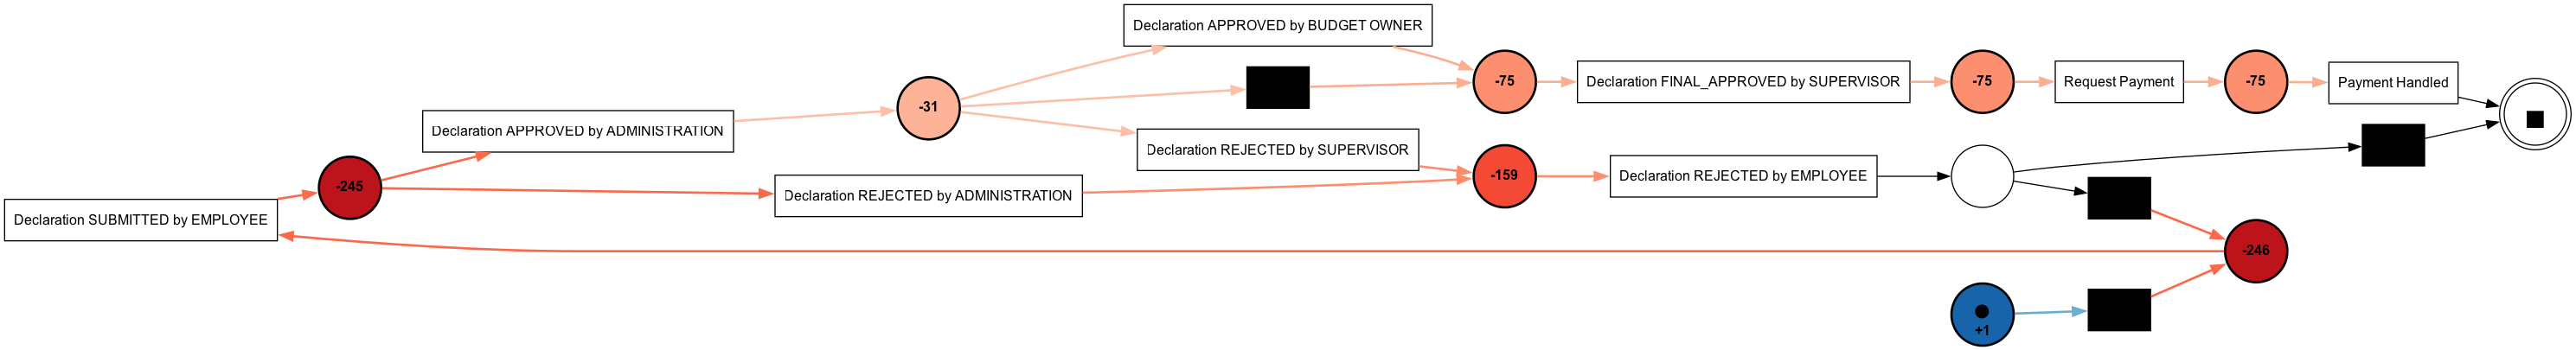








Version: full span - Cluster: 7


replaying log with TBR, completed traces ::   0%|          | 0/16 [00:00<?, ?it/s]

replaying log with TBR, completed traces ::   0%|          | 0/85 [00:00<?, ?it/s]

replaying log with TBR, completed traces ::   0%|          | 0/16 [00:00<?, ?it/s]

904 events, 110 cases


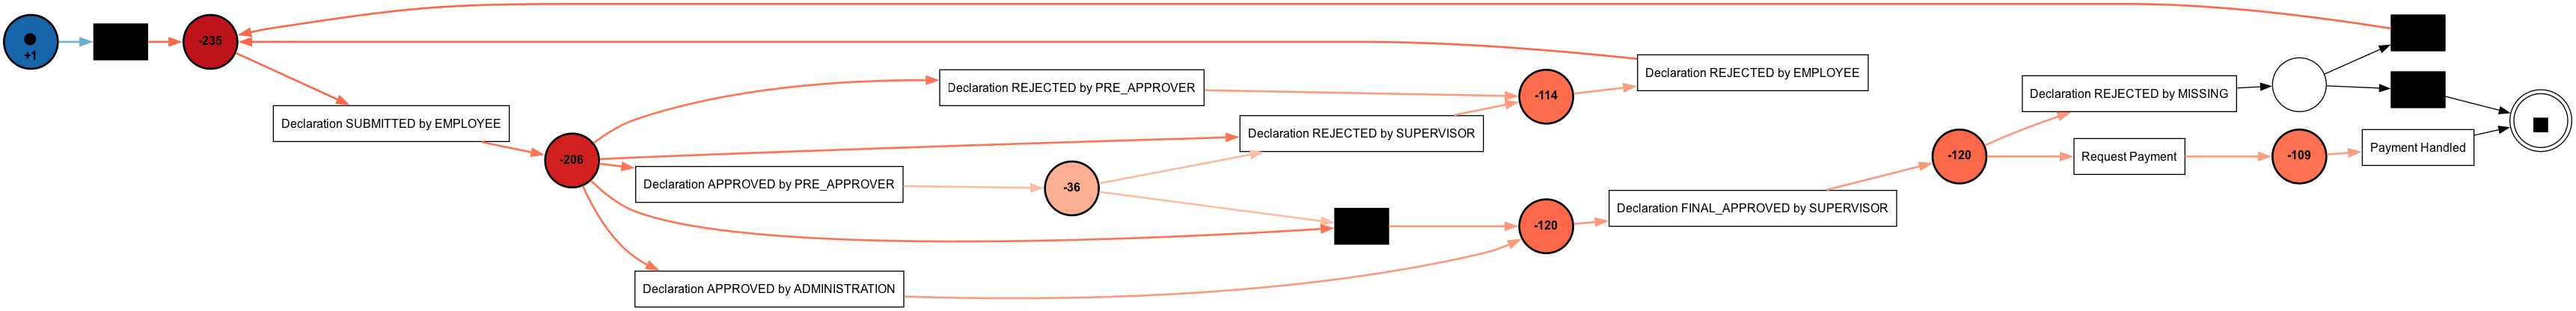

Version: from 2018 - Cluster: 7


replaying log with TBR, completed traces ::   0%|          | 0/4 [00:00<?, ?it/s]

replaying log with TBR, completed traces ::   0%|          | 0/4 [00:00<?, ?it/s]

replaying log with TBR, completed traces ::   0%|          | 0/4 [00:00<?, ?it/s]

174 events, 60 cases


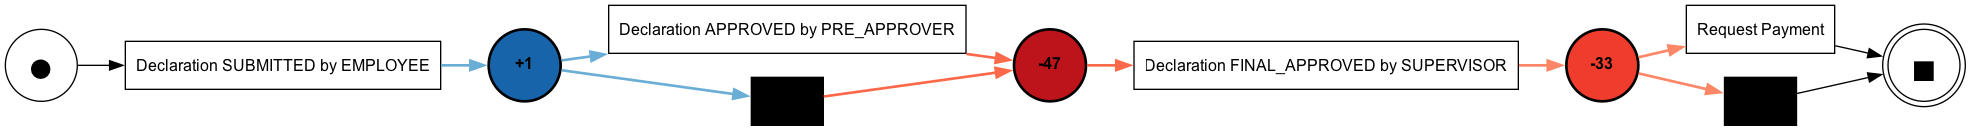

Version: before 2018 - Cluster: 7


replaying log with TBR, completed traces ::   0%|          | 0/15 [00:00<?, ?it/s]

replaying log with TBR, completed traces ::   0%|          | 0/30 [00:00<?, ?it/s]

replaying log with TBR, completed traces ::   0%|          | 0/15 [00:00<?, ?it/s]

305 events, 62 cases


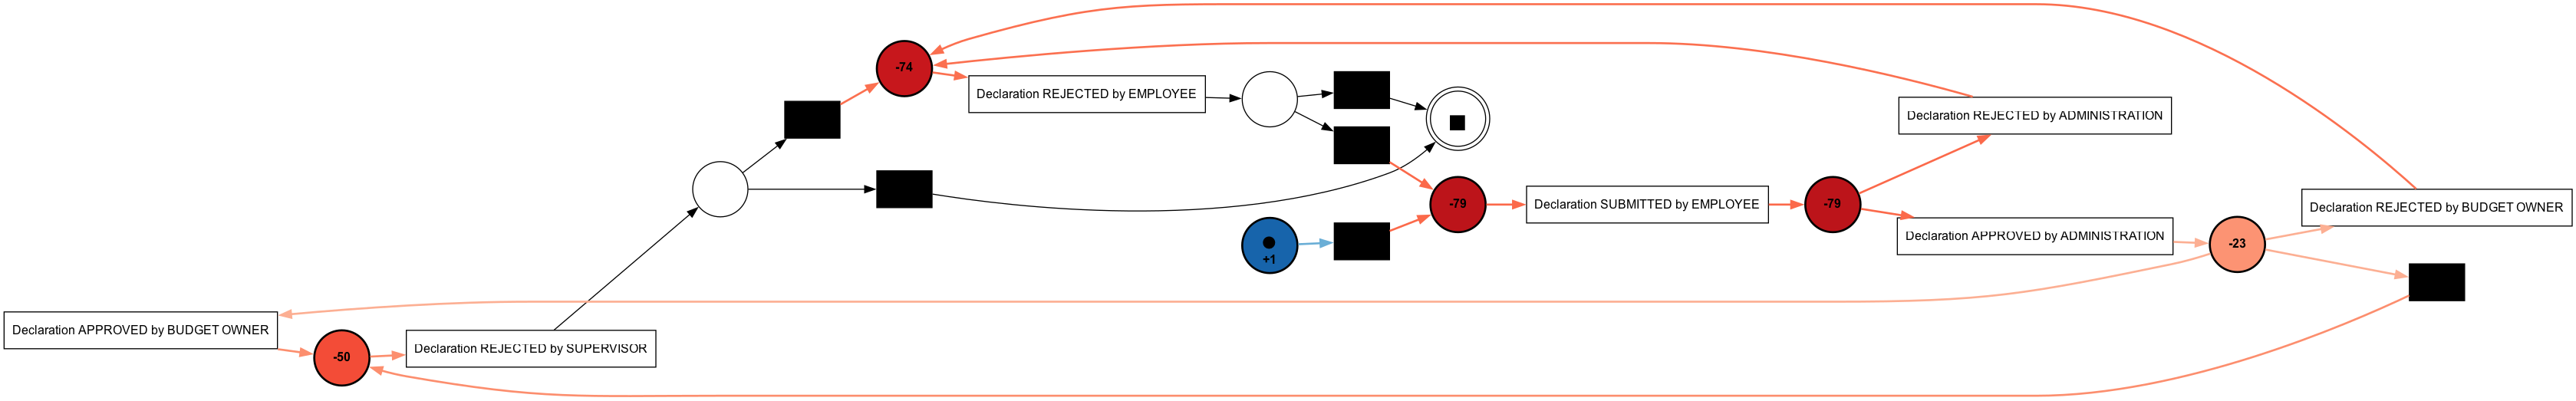








Version: full span - Cluster: 8


replaying log with TBR, completed traces ::   0%|          | 0/3 [00:00<?, ?it/s]

replaying log with TBR, completed traces ::   0%|          | 0/22 [00:00<?, ?it/s]

replaying log with TBR, completed traces ::   0%|          | 0/3 [00:00<?, ?it/s]

2789 events, 348 cases


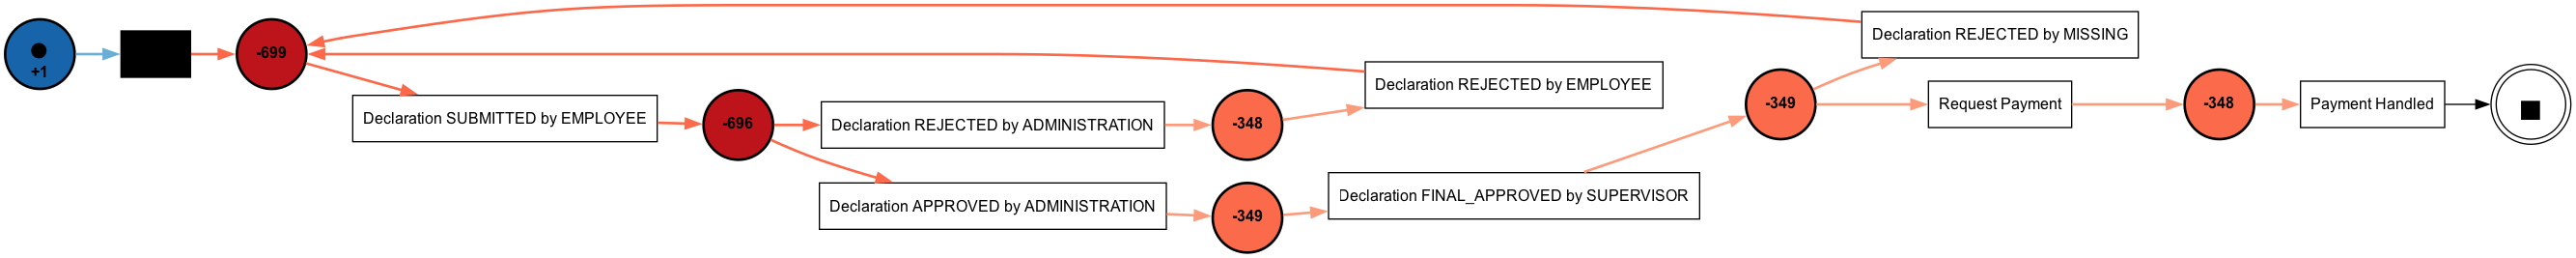

Version: from 2018 - Cluster: 8


replaying log with TBR, completed traces ::   0%|          | 0/5 [00:00<?, ?it/s]

replaying log with TBR, completed traces ::   0%|          | 0/32 [00:00<?, ?it/s]

replaying log with TBR, completed traces ::   0%|          | 0/5 [00:00<?, ?it/s]

110 events, 11 cases


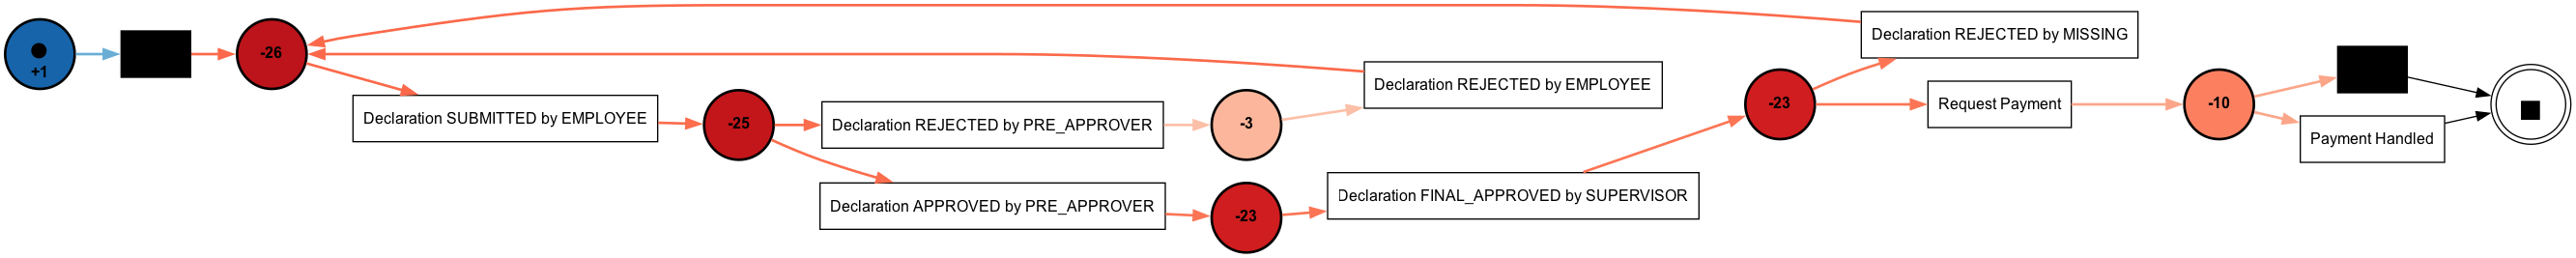

Version: before 2018 - Cluster: 8


replaying log with TBR, completed traces ::   0%|          | 0/3 [00:00<?, ?it/s]

replaying log with TBR, completed traces ::   0%|          | 0/22 [00:00<?, ?it/s]

replaying log with TBR, completed traces ::   0%|          | 0/3 [00:00<?, ?it/s]

1700 events, 189 cases


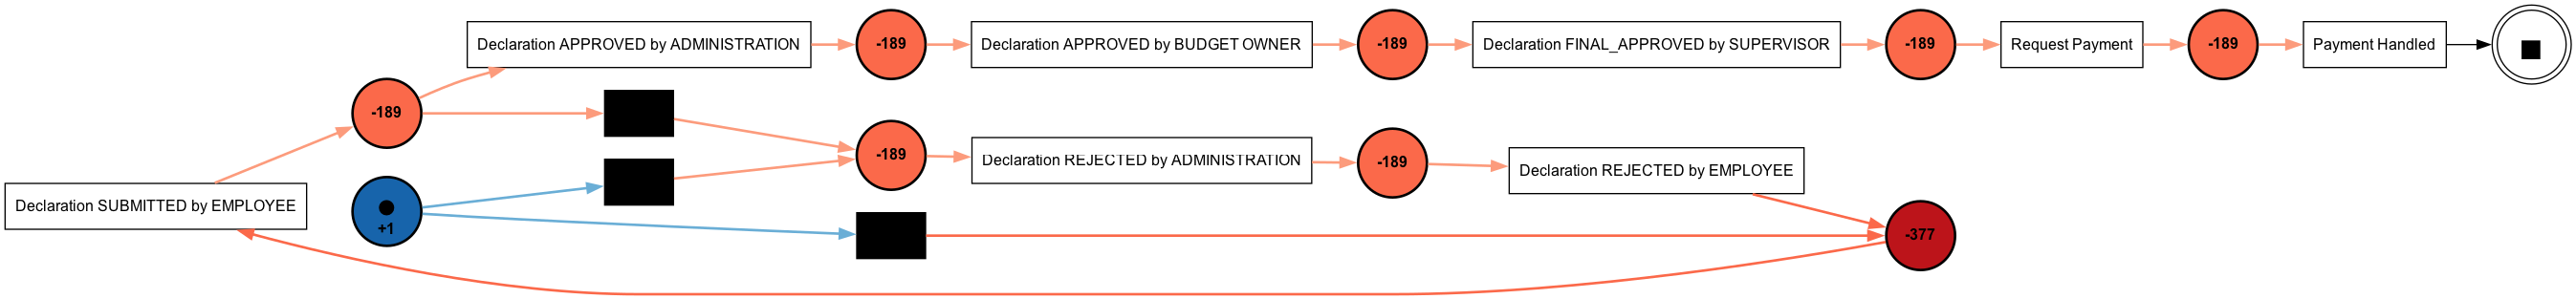








Version: full span - Cluster: 9


replaying log with TBR, completed traces ::   0%|          | 0/3 [00:00<?, ?it/s]

replaying log with TBR, completed traces ::   0%|          | 0/9 [00:00<?, ?it/s]

replaying log with TBR, completed traces ::   0%|          | 0/3 [00:00<?, ?it/s]

2946 events, 584 cases


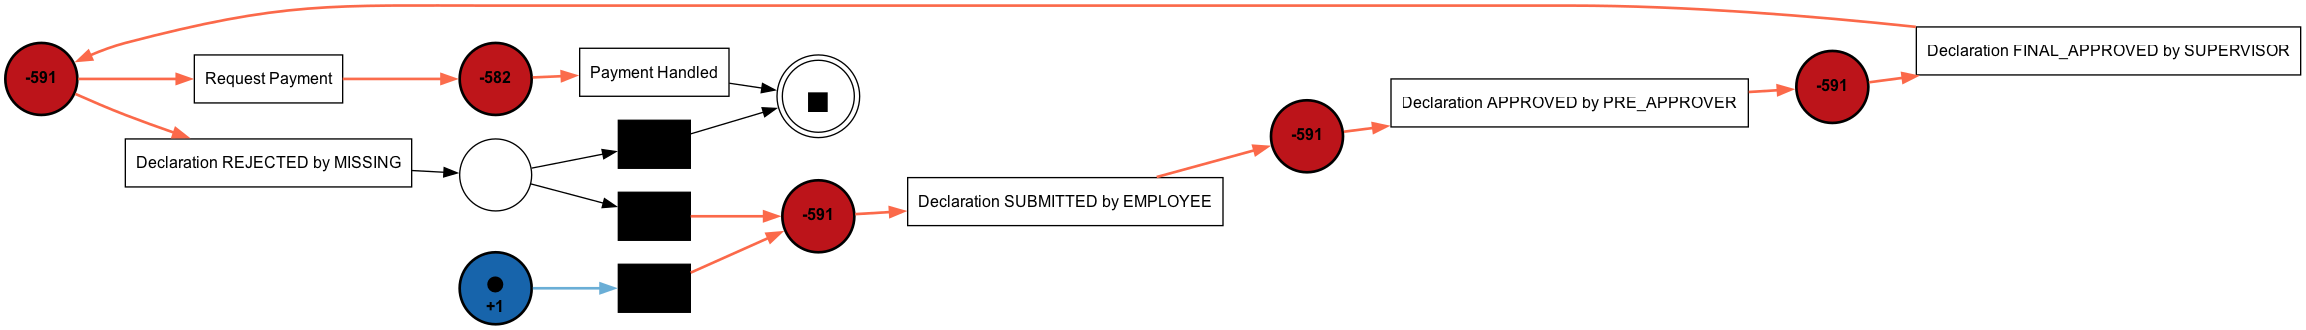

Version: from 2018 - Cluster: 9


replaying log with TBR, completed traces ::   0%|          | 0/2 [00:00<?, ?it/s]

replaying log with TBR, completed traces ::   0%|          | 0/14 [00:00<?, ?it/s]

replaying log with TBR, completed traces ::   0%|          | 0/2 [00:00<?, ?it/s]

88 events, 10 cases


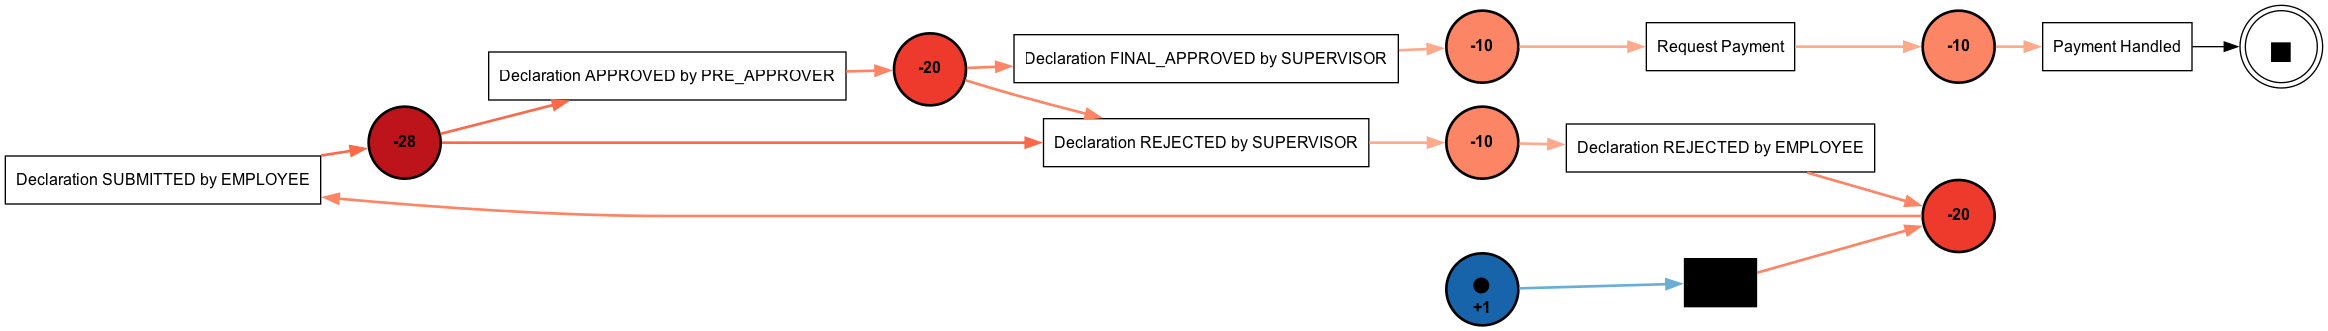

Version: before 2018 - Cluster: 9


replaying log with TBR, completed traces ::   0%|          | 0/4 [00:00<?, ?it/s]

replaying log with TBR, completed traces ::   0%|          | 0/22 [00:00<?, ?it/s]

replaying log with TBR, completed traces ::   0%|          | 0/4 [00:00<?, ?it/s]

836 events, 93 cases


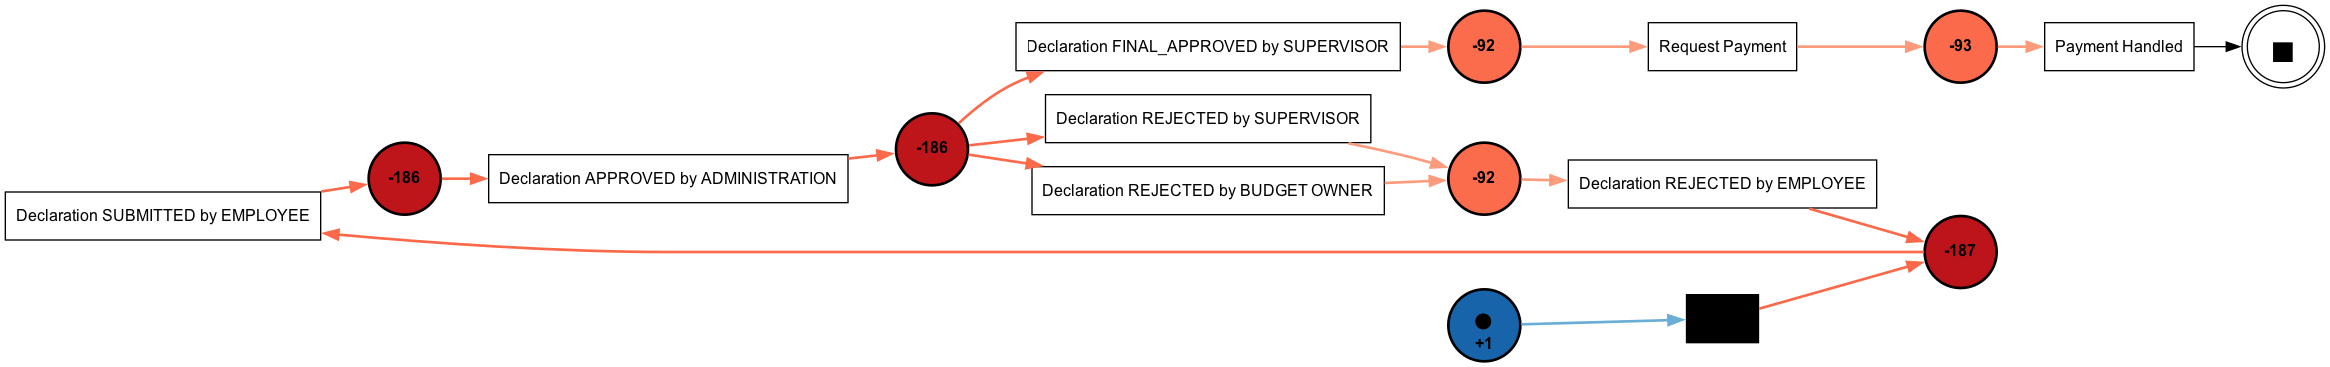

In [51]:
for x in range(len(step3[0])):
    for j, log in enumerate(LOG_VERSIONS):
        if j == 0:
            name = "full span"
        elif j == 1:
            name = "from 2018"
        else:
            name = "before 2018"
        print(f"Version: {name} - Cluster: {x}")
        visualize_single_log(_cluster=step3[j][x], df=step3[j][x])
    print("\n\n\n\n\n\n")